In [1]:
import io
from glob import glob
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.style as mpstyle
from matplotlib.ticker import ScalarFormatter
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.patches import Patch, Rectangle, FancyArrow
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mpcolors

from osgeo import ogr
import cartopy.crs as ccrs
from shapely.geometry import LineString, Point

from tathu.io import pgis
from tathu.geometry.transform import ogr2shapely
from tathu.geometry.utils import fitEllipse, extractCoordinates2NumpyArray

from my_secrets import postgis_pwd


def bytea2nparray(bytea):
    '''Converts Numpy Array from Postgres to python.'''
    bdata = io.BytesIO(bytea)
    bdata.seek(0)
    return np.load(bdata)


# Plot style
mpstyle.use("seaborn-whitegrid")
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

# OGR exceptions for conversions
ogr.UseExceptions()

In [2]:
# Load systems_filtered, systems
db = pgis.Loader("localhost", "goamazon_geo", "camilacl", postgis_pwd("camilacl"), "systems_filtered")
db_full = pgis.Loader("localhost", "goamazon_geo", "camilacl", postgis_pwd("camilacl"), "systems")
names = db.loadNames()
names_full = db_full.loadNames()
print(len(names))
print(len(names_full))

5976
91613


## Verificando famílias muito longas

Duração maior que 12h

In [ ]:
query = '''SELECT name, elapsed_time FROM
        (SELECT name, EXTRACT(epoch FROM (max(date_time) - min(date_time)))/60/60 AS elapsed_time
        FROM systems_filtered GROUP BY name) AS duration WHERE elapsed_time >= 8 ORDER BY elapsed_time DESC'''
fams = [q[0] for q in db.query(query)]
print(len(fams))
durations = [q[1] for q in db.query(query)]
print(len(durations))

In [ ]:
fams[:5]

In [ ]:
durations[:5]

## Verificando repetição de nomes

Intervalo entre timestamps maior que o máximo permitido (60 min)

In [ ]:
query = '''SELECT name, diff
    FROM (SELECT name, (DATE_PART('day', date_time - lag(date_time) over (partition by name order by date_time)) * 24 +
    DATE_PART('hour', date_time - lag(date_time) over (partition by name order by date_time)) * 60 +
    DATE_PART('minute', date_time - lag(date_time) over (partition by name order by date_time))) AS diff FROM systems) AS diiff WHERE diff > 60'''
fams = [q[0] for q in db.query(query)]
diff = [q[1] for q in db.query(query)]
print(len(fams))

In [ ]:
fams

In [ ]:
diff

## Verificando famílias muito curtas (1 step) sem relações
Duração de 1 step, status de `SPONTANEUOS_GENERATION` e não estando em `relations`

In [8]:
query = '''SELECT name, cc FROM (SELECT name, COUNT(*) AS cc FROM systems_filtered GROUP BY name) AS ccc WHERE cc = 1'''
fams = [q[0] for q in db.query(query)]
cc = [q[1] for q in db.query(query)]
print(len(fams))

643


In [9]:
query = "SELECT name, event FROM systems_filtered WHERE name IN " + "('" + "','".join(fams) + "') AND event = 'SPONTANEOUS_GENERATION'"
qq = [q[0] for q in db.query(query)]
print(len(qq))

141


In [5]:
query = (
    "SELECT name, relations FROM systems "
    + "WHERE relations IN "
    + "(ARRAY['" + "'],ARRAY['".join(qq) + "'])"
)
names = [q[0] for q in db.query(query)]
rels = [q[1] for q in db.query(query)]
print(len(rels))

operator does not exist: character varying[] = text[]
LINE 1: ...LECT name, relations FROM systems WHERE relations IN (ARRAY[...
                                                             ^
HINT:  No operator matches the given name and argument types. You might need to add explicit type casts.



TypeError: 'NoneType' object is not iterable

In [ ]:
rels[:5]

## Extraindo dados para estatísticas

- `count`
- `duration`
- `max`, `mean`
- `event`
- `date_time`
- `gld`
- `geom`

##### From systems_filtered

In [3]:
# From systems_filtered

query = '''SELECT count FROM systems_filtered ORDER BY name, date_time ASC'''
areas = [q[0] for q in db.query(query)]
print(len(areas))

query = '''SELECT MAX(count) FROM systems_filtered GROUP BY name'''
max_areas = [q[0] for q in db.query(query)]
print(len(max_areas))

query = '''SELECT name, elapsed_time FROM
        (SELECT name, EXTRACT(epoch FROM (max(date_time) - min(date_time))/60) AS elapsed_time
        FROM systems_filtered GROUP BY name) AS duration'''
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]
print(len(durations))

query = '''SELECT max FROM systems_filtered ORDER BY name, date_time ASC'''
zmax = [q[0] for q in db.query(query)]
print(len(zmax))

query = '''SELECT mean FROM systems_filtered ORDER BY name, date_time ASC'''
zmean = [q[0] for q in db.query(query)]
print(len(zmean))

query = '''SELECT event FROM systems_filtered ORDER BY name, date_time ASC'''
event = [q[0] for q in db.query(query)]
print(len(event))

query = '''SELECT date_time FROM systems_filtered ORDER BY name, date_time ASC'''
timestamp = [q[0] for q in db.query(query)]
print(len(timestamp))

query = '''SELECT gld FROM systems_filtered ORDER BY name, date_time ASC'''
gld = [q[0] for q in db.query(query)]
print(len(gld))

query = '''SELECT DISTINCT ON (name) ST_AsBinary(geom) as wkb FROM systems_filtered ORDER BY name, date_time ASC'''
first_geoms = [ogr.CreateGeometryFromWkb(bytes(q[0])) for q in db.query(query)]
print(len(first_geoms))

query = '''SELECT DISTINCT ON (name) date_time FROM systems_filtered ORDER BY name, date_time ASC'''
first_dates = [q[0] for q in db.query(query)]
print(len(first_dates))

query = '''SELECT name, ST_AsBinary(geom) as wkb FROM systems_filtered ORDER BY name, date_time ASC'''
geoms_names = [q[0] for q in db.query(query)]
geoms = [ogr.CreateGeometryFromWkb(bytes(q[1])) for q in db.query(query)]
print(len(geoms))

query = '''SELECT echotop_0, echotop_20, echotop_40, echotop0_kmmin, echotop20_kmmin, echotop40_kmmin FROM systems_filtered ORDER BY name, date_time ASC'''
echo0 = [q[0] for q in db.query(query)]
print(len(echo0))
echo20 = [q[1] for q in db.query(query)]
print(len(echo20))
echo40 = [q[2] for q in db.query(query)]
print(len(echo40))
decho0 = [q[3] for q in db.query(query)]
print(len(decho0))
decho20 = [q[4] for q in db.query(query)]
print(len(decho20))
decho40 = [q[5] for q in db.query(query)]
print(len(decho40))

query = '''SELECT vil_kgm2, vii_kgm2 FROM systems_filtered ORDER BY name, date_time ASC'''
vil = [bytea2nparray(q[0])/10000 for q in db.query(query)]
print(len(vil))
vii = [bytea2nparray(q[1])/10000 for q in db.query(query)]
print(len(vii))

query = '''SELECT z_freq FROM systems_filtered ORDER BY name, date_time ASC'''
zfreq = [np.int64(bytea2nparray(q[0])) for q in db.query(query)]
print(len(zfreq))

query = '''SELECT nae_s_1 FROM systems_filtered ORDER BY name, date_time ASC'''
nae = [q[0] for q in db.query(query)]
print(len(nae))

query = '''SELECT gld_strmin FROM systems_filtered ORDER BY name, date_time ASC'''
dgld = [q[0] for q in db.query(query)]
print(len(dgld))

40394
5976
5976
40394
40394
40394
40394
40394
5976
5976
40394
40394
40394
40394
40394
40394
40394
40394
40394
40394
40394
40394


##### From systems

In [4]:
# From systems

query = (
    "SELECT count FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') ORDER BY name, date_time ASC"
)
areas_full = [q[0] for q in db_full.query(query)]
print(len(areas_full))

query = (
    "SELECT MAX(count) FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') GROUP BY name ORDER BY name"
)
max_areas_full = [q[0] for q in db_full.query(query)]
print(len(max_areas_full))

query = (
    "SELECT elapsed_time, name FROM (SELECT name, EXTRACT(epoch FROM (max(date_time)"
    " - min(date_time))/60) AS elapsed_time FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') GROUP BY name ORDER BY name) AS duration"
)
durations_full = [q[0] for q in db_full.query(query)]
namesd_full = [q[1] for q in db_full.query(query)]
print(len(durations_full))

query = (
    "SELECT max FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') ORDER BY name, date_time ASC"
)
zmax_full = [q[0] for q in db_full.query(query)]
print(len(zmax_full))

query = (
    "SELECT mean FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') ORDER BY name, date_time ASC"
)
zmean_full = [q[0] for q in db_full.query(query)]
print(len(zmean_full))

query = (
    "SELECT event FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') ORDER BY name, date_time ASC"
)
event_full = [q[0] for q in db_full.query(query)]
print(len(event_full))

query = (
    "SELECT date_time, name FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') ORDER BY name, date_time ASC"
)
timestamp_full = [q[0] for q in db_full.query(query)]
namest_full = [q[1] for q in db_full.query(query)]
print(len(timestamp_full))

query = (
    "SELECT DISTINCT ON (name) date_time FROM systems WHERE name NOT IN"
    " ('c8a8ed48-2db2-4eb7-b5e4-0feaf6452c5e',"
    " '1a332204-12fe-4abb-bd9d-b73f5450dd03',"
    " 'c5f70bb0-5cb3-4b09-83f9-fa003b938f65',"
    " '50f14b96-efa7-4dee-aa1b-510ece86172a') ORDER BY name, date_time ASC"
)
first_dates_full = [q[0] for q in db_full.query(query)]
print(len(first_dates_full))


322896
91609
91609
322896
322896
322896
322896
91609


## Convertendo para um df do Pandas e plotando

In [5]:
# From systems_filtered
systems_all = pd.DataFrame({"area": areas, "max": zmax, "mean": zmean, "event": event, "timestamp": timestamp, "gld": gld, "geom_name": geoms_names, "geom": geoms, "echotop_0": echo0, "echotop_20": echo20, "echotop_40": echo40, "dechotop_0": decho0, "dechotop_20": decho20, "dechotop_40": decho40, "vil": vil, "vii": vii, "zfreq": zfreq, "nae": nae, "dgld": dgld})
systems_all.timestamp = systems_all.timestamp.dt.tz_localize("UTC")
systems_all.timestamp = systems_all.timestamp.dt.tz_convert('America/Manaus')
systems_all.nae = systems_all.nae*1e6
systems_all[["echotop_0", "echotop_20", "echotop_40"]] = systems_all[["echotop_0", "echotop_20", "echotop_40"]].astype(int)
systems_all[["dechotop_0", "dechotop_20", "dechotop_40", "dgld"]] = systems_all[["dechotop_0", "dechotop_20", "dechotop_40", "dgld"]].round(1)
systems_per = pd.DataFrame({"name": names, "max_area": max_areas, "duration": [float(dur)/60 for dur in durations], "geom": first_geoms, "timestamp": first_dates})
systems_per.timestamp = systems_per.timestamp.dt.tz_localize("UTC")
systems_per.timestamp = systems_per.timestamp.dt.tz_convert('America/Manaus')

# From systems
systems_all_full = pd.DataFrame({"name":namest_full, "area": areas_full, "max": zmax_full, "mean": zmean_full, "event": event_full, "timestamp": timestamp_full})
systems_all_full.timestamp = systems_all_full.timestamp.dt.tz_localize("UTC")
systems_all_full.timestamp = systems_all_full.timestamp.dt.tz_convert('America/Manaus')
systems_per_full = pd.DataFrame({"max_area": max_areas_full, "duration": [float(dur)/60 for dur in durations_full], "timestamp": first_dates_full})
systems_per_full.timestamp = systems_per_full.timestamp.dt.tz_localize("UTC")
systems_per_full.timestamp = systems_per_full.timestamp.dt.tz_convert('America/Manaus')

# Plot labels
class_labels = ["SPONTANEOUS\nGENERATION", "CONTINUITY", "SPLIT", "MERGE"]
time_ticks = pd.date_range(start="2014-01-01", end="2015-12-31", freq="1M")
time_labels = time_ticks.strftime("%b %Y")
time_ticks_2 = pd.date_range(start="00:00", end="23:00", freq="1H")
time_labels_2 = time_ticks_2.strftime("%H:%M")
custom_legend = [Patch(facecolor="w", edgecolor="k", label="Raw"),
                Patch(facecolor="k", edgecolor="k", label="Filtered")]
custom_legend_all = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all)) + ")")]
custom_legend_per = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per)) + ")")]

### Area

In [ ]:
fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_area = systems_all_full.area.plot.hist(bins=range(0, 63000, 1000), grid=True, color="w", edgecolor="k", ax=ax1)
systems_all.area.plot.hist(bins=range(0, 63000, 1000), grid=True, color="k", edgecolor="k", ax=ax1)
ax_area.set_yscale("log")
# ax_area.yaxis.set_major_formatter(ScalarFormatter())
ax_area.set_ylim(bottom=1)
ax_area.set_ylabel("Count")
ax_area.set_title("Area of Clusters")
ax_area.set_title("a", loc="left", fontweight="bold", size=16)
ax_area.legend(handles=custom_legend)

ax2 = fig.add_subplot(gs[1,0])
ax_area2 = systems_per_full.max_area.plot.hist(bins=range(0, 63000, 1000), grid=True, color="w", edgecolor="k", ax=ax2)
systems_per.max_area.plot.hist(bins=range(0, 63000, 1000), grid=True, color="k", edgecolor="k", ax=ax2)
ax_area2.set_yscale("log")
# ax_area2.yaxis.set_major_formatter(ScalarFormatter())
ax_area2.set_ylim(bottom=1)
ax_area2.set_xlabel("km²")
ax_area2.set_ylabel("Count")
ax_area2.set_title("Max Area of Convective Systems")
ax_area2.legend(handles=custom_legend)

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_area.png", dpi=300, facecolor="none")

### NAE (Normalized Area Expansion)

In [ ]:
names_2h = systems_per.loc[systems_per.duration <= 2].name
names_4h = systems_per.loc[(systems_per.duration > 2) & (systems_per.duration <= 4)].name
names_6h = systems_per.loc[(systems_per.duration > 4) & (systems_per.duration <= 6)].name
names_maxh = systems_per.loc[systems_per.duration > 6].name

In [ ]:
fig = plt.figure(figsize=(7,10))
gs = fig.add_gridspec(5,1)

ax1 = fig.add_subplot(gs[0,0])
ax_area = systems_all.nae.plot.hist(bins=range(-47000, 1500, 500), grid=True, color="k", edgecolor="k", ax=ax1)
ax_area.set_yscale("log")
# ax_area.yaxis.set_major_formatter(ScalarFormatter())
ax_area.set_ylim(bottom=1)
ax_area.set_ylabel("Count")
ax_area.set_title("All Clusters")

ax2 = fig.add_subplot(gs[1,0])
ax_area = systems_all.loc[systems_all.geom_name.isin(names_2h)].nae.plot.hist(bins=range(-47000, 1500, 500), grid=True, color="k", edgecolor="k", ax=ax2)
ax_area.set_yscale("log")
# ax_area.yaxis.set_major_formatter(ScalarFormatter())
ax_area.set_ylim(bottom=1)
ax_area.set_ylabel("Count")
ax_area.set_title("Convective Systems ≤ 2h (total = " + str(systems_all.loc[systems_all.geom_name.isin(names_2h)].count().nae) + ")")

ax3 = fig.add_subplot(gs[2,0])
ax_area = systems_all.loc[systems_all.geom_name.isin(names_4h)].nae.plot.hist(bins=range(-47000, 1500, 500), grid=True, color="k", edgecolor="k", ax=ax3)
ax_area.set_yscale("log")
# ax_area.yaxis.set_major_formatter(ScalarFormatter())
ax_area.set_ylim(bottom=1)
ax_area.set_ylabel("Count")
ax_area.set_title("Convective Systems > 2h - ≤ 4h (total = " + str(systems_all.loc[systems_all.geom_name.isin(names_4h)].count().nae) + ")")

ax4 = fig.add_subplot(gs[3,0])
ax_area = systems_all.loc[systems_all.geom_name.isin(names_6h)].nae.plot.hist(bins=range(-47000, 1500, 500), grid=True, color="k", edgecolor="k", ax=ax4)
ax_area.set_yscale("log")
# ax_area.yaxis.set_major_formatter(ScalarFormatter())
ax_area.set_ylim(bottom=1)
ax_area.set_ylabel("Count")
ax_area.set_title("Convective Systems > 4h - ≤ 6h (total = " + str(systems_all.loc[systems_all.geom_name.isin(names_6h)].count().nae) + ")")

ax5 = fig.add_subplot(gs[4,0])
ax_area = systems_all.loc[systems_all.geom_name.isin(names_maxh)].nae.plot.hist(bins=range(-47000, 1500, 500), grid=True, color="k", edgecolor="k", ax=ax5)
ax_area.set_yscale("log")
# ax_area.yaxis.set_major_formatter(ScalarFormatter())
ax_area.set_ylim(bottom=1)
ax_area.set_ylabel("Count")
ax_area.set_xlabel("$10^6 s^{-1}$")
ax_area.set_title("Convective Systems > 6h (total = " + str(systems_all.loc[systems_all.geom_name.isin(names_maxh)].count().nae) + ")")

fig.suptitle("Normalized Area Expansion of Clusters", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_nae.png", dpi=300, facecolor="none")

### Refletividade média/máxima

In [ ]:
fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_maxmean = systems_all_full[["max", "mean"]].plot.hist(bins=range(20, 70, 5), grid=True, weights=np.ones(len(systems_all_full))/len(systems_all_full)*100, color=("#3C2692","#F1F1F1"), edgecolor="k", alpha=.5, ax=ax1)
ax_maxmean.set_title("Raw clusters (total = " + str(len(systems_all_full)) + ")")
ax_maxmean.set_ylabel("Frequency (%)")

ax2 = fig.add_subplot(gs[1,0])
ax_maxmean = systems_all[["max", "mean"]].plot.hist(bins=range(20, 70, 5), grid=True, weights=np.ones(len(systems_all))/len(systems_all)*100, color=("#3C2692","#F1F1F1"), edgecolor="k", alpha=.5, ax=ax2)
ax_maxmean.set_title("Filtered clusters (total = " + str(len(systems_all)) + ")")
ax_maxmean.set_ylabel("Frequency (%)")
ax_maxmean.set_xlabel("dBZ")

fig.suptitle("3-km Reflectivity", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_z.png", dpi=300, facecolor="none")

### Classificação

In [ ]:
# Ver % de CSs com split/merge

print(len(systems_all_full.name.unique()))
print(len(systems_all_full.loc[systems_all_full.event.isin(["SPLIT", "MERGE"])].name.unique()))
print(len(systems_all.geom_name.unique()))
print(len(systems_all.loc[systems_all.event.isin(["SPLIT", "MERGE"])].geom_name.unique()))

In [ ]:
files = glob("/home/camilacl/git/tathu/sipam-tracking/in/goamazon/*")
dt = []
for file in files:
    filelist = open(file, "r")
    dt.append(datetime.strptime([line.strip() for line in filelist][0][61:73], "%Y%m%d%H%M"))

In [ ]:
dts = pd.Series(dt)
dts = dts.dt.tz_localize("UTC")
dts = dts.dt.tz_convert('America/Manaus')

In [ ]:
classes = pd.DataFrame({"Raw": len(systems_all_full.groupby("name")),
                        "Filtered": len(systems_all.groupby("geom_name"))}, index=["Convective Systems (total)"])
classes.loc["CS spontaneously generated (%)"] = [len(systems_all_full.loc[(systems_all_full.event == "SPONTANEOUS_GENERATION") & (~systems_all_full.timestamp.isin(dts))])/classes["Raw"][0]*100,
                                                  len(systems_all.loc[(systems_all.event == "SPONTANEOUS_GENERATION") & (~systems_all.timestamp.isin(dts))])/classes["Filtered"][0]*100]
classes.loc["CS with split/merge (%)"] = [len(systems_all_full.loc[systems_all_full.event.isin(["SPLIT", "MERGE"])].groupby("name"))/classes["Raw"][0]*100,
                                          len(systems_all.loc[systems_all.event.isin(["SPLIT", "MERGE"])].groupby("geom_name"))/classes["Filtered"][0]*100]
classes.loc["CS with full lifecycle (%)"] = [len(systems_all_full.sort_values("timestamp").groupby("name").tail(1).set_index("event").loc["CONTINUITY"])/classes["Raw"][0]*100,
                                             len(systems_all.sort_values("timestamp").groupby("geom_name").tail(1).set_index("event").loc["CONTINUITY"])/classes["Filtered"][0]*100]

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=classes.values.astype(int), colLabels=classes.columns, rowLabels=classes.index, loc="center", colWidths=[0.2,0.2])
for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

fig.tight_layout()


In [ ]:
classes = pd.DataFrame({"full": (systems_all_full["event"].value_counts()/len(systems_all_full)*100),
                        "no-full": (systems_all["event"].value_counts()/len(systems_all)*100)}).reindex(index=["SPONTANEOUS_GENERATION", "CONTINUITY", "SPLIT", "MERGE"])

fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

ax = fig.add_subplot(gs[0,0])
ax_class = classes.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax)
ax.bar_label(ax.containers[0], fmt="%.0f")
ax.bar_label(ax.containers[1], fmt="%.0f")
ax_class.grid(axis="x")
ax_class.set_xticks(ticks=range(4), labels=class_labels, rotation=0)
ax_class.set_ylabel("Frequency (%)")
ax_class.set_ylim(top=80)
ax_class.set_title("Clusters Classification", fontweight="bold")
ax_class.legend(handles=custom_legend_all)

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_class.png", dpi=300, facecolor="none")

### Duração

In [ ]:
fig = plt.figure(figsize=(7,3))
gs = fig.add_gridspec(1,1)

ax5 = fig.add_subplot(gs[0,0])
ax_dur = systems_per_full.duration.plot.hist(bins=range(0, 27), grid=True, color="w", edgecolor="k", ax=ax5)
systems_per.duration.plot.hist(bins=range(0, 27), grid=True, color="k", edgecolor="k", ax=ax5)
ax_dur.set_yscale("log")
# ax_dur.yaxis.set_major_formatter(ScalarFormatter())
ax_dur.set_ylim(bottom=1)
ax_dur.set_ylabel("Count")
ax_dur.set_xlabel("Hours")
ax_dur.set_title("Convective Systems Duration", fontweight="bold")
ax_dur.legend(handles=custom_legend)

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_dur.png", dpi=300, facecolor="none")

In [ ]:
cs_splmrg_full = systems_all_full.loc[systems_all_full.event.isin(["SPLIT", "MERGE"])].groupby("name").count().index.tolist()
cs_splmrg = systems_all.loc[systems_all.event.isin(["SPLIT", "MERGE"])].groupby("geom_name").count().index.tolist()
cs_lf_full = systems_all_full.sort_values("timestamp").groupby("name").tail(1).set_index("event").loc["CONTINUITY"].name.to_list()
cs_lf = systems_all.sort_values("timestamp").groupby("geom_name").tail(1).set_index("event").loc["CONTINUITY"].geom_name.to_list()

fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(3, 1)

ax = fig.add_subplot(gs[0, 0])
axplot = systems_per_full.duration.plot.hist(
    bins=range(0, 27), grid=True, color="w", edgecolor="k", ax=ax
)
systems_per.duration.plot.hist(
    bins=range(0, 27), grid=True, color="k", edgecolor="k", ax=ax
)
axplot.set_yscale("log")
axplot.set_ylim(bottom=1)
axplot.set_ylabel("Count")
axplot.set_xlabel("Hours")
axplot.set_title("All Convective Systems")
axplot.legend(handles=legend_rf)

ax2 = fig.add_subplot(gs[1, 0])
axplot = systems_per_full.loc[systems_per_full.name.isin(cs_splmrg_full)].duration.plot.hist(
    bins=range(0, 27), grid=True, color="w", edgecolor="k", ax=ax2
)
systems_per.loc[systems_per.name.isin(cs_splmrg)].duration.plot.hist(
    bins=range(0, 27), grid=True, color="k", edgecolor="k", ax=ax2
)
axplot.set_yscale("log")
axplot.set_ylim(bottom=1)
axplot.set_ylabel("Count")
axplot.set_xlabel("Hours")
axplot.set_title("Convective Systems with Split/Merge")
axplot.legend(handles=legend_rf)

ax3 = fig.add_subplot(gs[2, 0])
axplot = systems_per_full.loc[systems_per_full.name.isin(cs_lf_full)].duration.plot.hist(
    bins=range(0, 27), grid=True, color="w", edgecolor="k", ax=ax3
)
systems_per.loc[systems_per.name.isin(cs_lf)].duration.plot.hist(
    bins=range(0, 27), grid=True, color="k", edgecolor="k", ax=ax3
)
axplot.set_yscale("log")
axplot.set_ylim(bottom=1)
axplot.set_ylabel("Count")
axplot.set_xlabel("Hours")
axplot.set_title("Convective Systems with Full Lifecycle")
axplot.legend(handles=legend_rf)

gs.tight_layout(fig)

plt.savefig(figpath + "exploratory_stats_dur.png", dpi=300, facecolor="none")


In [ ]:
durs = pd.DataFrame({"Raw": systems_per_full.groupby([pd.cut(systems_per_full.duration, [0,1,2,3,4,5,6,24])]).size(),
                     "Filtered": systems_per.groupby([pd.cut(systems_per.duration, [0,1,2,3,4,5,6,24])]).size()})
durs = durs.rename(
    index=dict(zip(durs.index.values,["CS duration ≤ 1h", "1h < CS duration ≤ 2h", "2h < CS duration ≤ 3h", "3h < CS duration ≤ 4h", "4h < CS duration ≤ 5h", "5h < CS duration ≤ 6h", "CS duration > 6h"])))
norm = mpcolors.LogNorm(1,100000)
colors = plt.cm.BuPu(norm(durs.values))

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=durs.values.astype(int), colLabels=durs.columns, cellColours=colors, rowLabels=durs.index, loc="center", colWidths=[0.2,0.2])
for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

fig.tight_layout()




### Duração por estação, IOP

In [ ]:
hourly_wet = pd.DataFrame(
    {
        "full": (
            systems_per_full_wet.duration.value_counts(
                bins=[0, 1, 2, 3, 4, 5, 6, 24]
            )
        ),
        "no-full": (
            systems_per_wet.duration.value_counts(
                bins=[0, 1, 2, 3, 4, 5, 6, 24]
            )
        ),
    }
)
hourly_dry = pd.DataFrame(
    {
        "full": (
            systems_per_full_dry.duration.value_counts(
                bins=[0, 1, 2, 3, 4, 5, 6, 24]
            )
        ),
        "no-full": (
            systems_per_dry.duration.value_counts(
                bins=[0, 1, 2, 3, 4, 5, 6, 24]
            )
        ),
    }
)
hourly_drytowet = pd.DataFrame(
    {
        "full": (
            systems_per_full_drytowet.duration.value_counts(
                bins=[0, 1, 2, 3, 4, 5, 6, 24]
            )
        ),
        "no-full": (
            systems_per_drytowet.duration.value_counts(
                bins=[0, 1, 2, 3, 4, 5, 6, 24]
            )
        ),
    }
)

hourly = pd.concat([hourly_dry, hourly_drytowet, hourly_wet], axis=1)
hourly = hourly.rename(
    index=dict(
        zip(
            hourly.index.values,
            [
                "CS duration ≤ 1h",
                "1h < CS duration ≤ 2h",
                "2h < CS duration ≤ 3h",
                "3h < CS duration ≤ 4h",
                "4h < CS duration ≤ 5h",
                "5h < CS duration ≤ 6h",
                "CS duration > 6h",
            ],
        )
    )
)
norm = mpcolors.LogNorm(1, 50000)
colors = plt.cm.BuPu(norm(hourly.values))

fig, ax = plt.subplots(figsize=(6, 2))

# hide axes
fig.patch.set_visible(False)
ax.axis("off")
ax.axis("tight")

header = ax.table(cellText=[['']*3],
                      colLabels=["Dry Season", "Dry-to-Wet Season", "Wet Season"],
                      loc='center',
                      bbox=[0, 0.1, 1, 1]
                      )
table = ax.table(
    cellText=hourly.values.astype(int),
    colLabels=hourly.columns,
    cellColours=colors,
    rowLabels=hourly.index,
    loc="center",
    bbox=[0, -0.5, 1.0, 1.0],
    colWidths=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
)
for (row, col), cell in header.get_celld().items():
    if row == 0:
        cell.set_text_props(fontproperties=FontProperties(weight="bold"))
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(fontproperties=FontProperties(weight="bold"))


In [ ]:
dur_labels = ["≤ 1", "≤ 2", "≤ 3", "≤ 4", "≤ 5", "≤ 6", "> 6"]

# Definição das estações/IOPs: Machado et al. (2018)
systems_per_full_wet = systems_per_full.loc[systems_per_full["timestamp"].dt.month.isin([1,2,3])]
systems_per_wet = systems_per.loc[systems_per["timestamp"].dt.month.isin([1,2,3])]
systems_per_full_dry = systems_per_full.loc[systems_per_full["timestamp"].dt.month.isin([8,9,10])]
systems_per_dry = systems_per.loc[systems_per["timestamp"].dt.month.isin([8,9,10])]
systems_per_full_drytowet = systems_per_full.loc[systems_per_full["timestamp"].dt.month.isin([11,12])]
systems_per_drytowet = systems_per.loc[systems_per["timestamp"].dt.month.isin([11,12])]

custom_legend_per_wet = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_wet)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_wet)) + ")")]
custom_legend_per_dry = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_dry)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_dry)) + ")")]
custom_legend_per_drytowet = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_drytowet)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_drytowet)) + ")")]

hourly_wet = pd.DataFrame({"full": (systems_per_full_wet.duration.value_counts(bins=[0, 1, 2, 3, 4, 5, 6, 24])/len(systems_per_full_wet)*100),
                        "no-full": (systems_per_wet.duration.value_counts(bins=[0, 1, 2, 3, 4, 5, 6, 24])/len(systems_per_wet)*100)})
hourly_dry = pd.DataFrame({"full": (systems_per_full_dry.duration.value_counts(bins=[0, 1, 2, 3, 4, 5, 6, 24])/len(systems_per_full_dry)*100),
                        "no-full": (systems_per_dry.duration.value_counts(bins=[0, 1, 2, 3, 4, 5, 6, 24])/len(systems_per_dry)*100)})
hourly_drytowet = pd.DataFrame({"full": (systems_per_full_drytowet.duration.value_counts(bins=[0, 1, 2, 3, 4, 5, 6, 24])/len(systems_per_full_drytowet)*100),
                        "no-full": (systems_per_drytowet.duration.value_counts(bins=[0, 1, 2, 3, 4, 5, 6, 24])/len(systems_per_drytowet)*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_dry.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_yscale("log")
ax_time.yaxis.set_major_formatter(ScalarFormatter())
ax_time.set_xticks(ticks=ax1.get_xticks(), labels=dur_labels, rotation=0)
ax_time.set_ylim(bottom=1)
ax_time.set_xlabel("")
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("Dry Season")
ax_time.legend(handles=custom_legend_per_dry, loc='upper right')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_drytowet.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_yscale("log")
ax_time2.yaxis.set_major_formatter(ScalarFormatter())
ax_time2.set_xticks(ticks=ax2.get_xticks(), labels=dur_labels, rotation=0)
ax_time2.set_ylim(bottom=1)
ax_time2.set_xlabel("")
ax_time2.set_ylabel("Frequency (%)")
ax_time2.set_title("Dry-to-Wet Season")
ax_time2.legend(handles=custom_legend_per_drytowet, loc='upper right')

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_wet.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax3)
ax_time3.grid(axis="x")
ax_time3.set_yscale("log")
ax_time3.yaxis.set_major_formatter(ScalarFormatter())
ax_time3.set_xticks(ticks=ax3.get_xticks(), labels=dur_labels, rotation=0)
ax_time3.set_ylim(bottom=1)
ax_time3.set_xlabel("Hours")
ax_time3.set_ylabel("Frequency (%)")
ax_time3.set_title("Wet Season")
ax_time3.legend(handles=custom_legend_per_wet, loc='upper right')

fig.suptitle("Convective systems duration", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_dur_seasons.png", dpi=300, facecolor="none")

In [ ]:
dur_labels = ["≤ 1", "≤ 2", "≤ 3", "≤ 4", "≤ 5", "≤ 6", "> 6"]

# Definição das estações/IOPs: Machado et al. (2018)
systems_per_full_iop1 = systems_per_full.loc[(systems_per_full["timestamp"].dt.month.isin([2,3])) & (systems_per_full["timestamp"].dt.year == 2014)]
systems_per_iop1 = systems_per.loc[(systems_per["timestamp"].dt.month.isin([2,3])) & (systems_per["timestamp"].dt.year == 2014)]
systems_per_full_iop2 = systems_per_full.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()
systems_per_iop2 = systems_per.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()

custom_legend_per_iop1 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_iop1)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_iop1)) + ")")]
custom_legend_per__iop2 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_iop2)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_iop2)) + ")")]

hourly_iop1 = pd.DataFrame({"full": (systems_per_full_iop1.duration.value_counts(bins=[0, 1, 2, 3, 4, 5, 6, 24])/len(systems_per_full_iop1)*100),
                        "no-full": (systems_per_iop1.duration.value_counts(bins=[0, 1, 2, 3, 4, 5, 6, 24])/len(systems_per_iop1)*100)})
hourly_iop2 = pd.DataFrame({"full": (systems_per_full_iop2.duration.value_counts(bins=[0, 1, 2, 3, 4, 5, 6, 24])/len(systems_per_full_iop2)*100),
                        "no-full": (systems_per_iop2.duration.value_counts(bins=[0, 1, 2, 3, 4, 5, 6, 24])/len(systems_per_iop2)*100)})

fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_iop1.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_yscale("log")
ax_time.yaxis.set_major_formatter(ScalarFormatter())
ax_time.set_xticks(ticks=ax1.get_xticks(), labels=dur_labels, rotation=0)
ax_time.set_ylim(bottom=1)
ax_time.set_xlabel("")
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("IOP1 (Wet Season)")
ax_time.legend(handles=custom_legend_per_dry, loc='upper right')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_iop2.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_yscale("log")
ax_time2.yaxis.set_major_formatter(ScalarFormatter())
ax_time2.set_xticks(ticks=ax2.get_xticks(), labels=dur_labels, rotation=0)
ax_time2.set_ylim(bottom=1)
ax_time2.set_xlabel("Hours")
ax_time2.set_ylabel("Frequency (%)")
ax_time2.set_title("IOP2 (Dry Season)")
ax_time2.legend(handles=custom_legend_per_drytowet, loc='upper right')

fig.suptitle("Convective systems duration", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_dur_iops.png", dpi=300, facecolor="none")

### Clusters por mês

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
custom_legend_all2 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all)) + ")"),
                Patch(facecolor="dodgerblue", edgecolor="dodgerblue", label="Wet season"),
                Patch(facecolor="red", edgecolor="red", label="Dry season")]

monthly = pd.DataFrame({"full": (systems_all_full.resample("1M", on="timestamp").count().timestamp/len(systems_all_full)*100),
                        "no-full": (systems_all.resample("1M", on="timestamp").count().timestamp/len(systems_all)*100)})

fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = monthly.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
# Wet/dry season bars
ax_time.axvspan(-0.5, 2.5, facecolor="dodgerblue", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(6.5, 9.5, facecolor="r", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(11.5, 14.5, facecolor="dodgerblue", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(18.5, 21.5, facecolor="r", edgecolor="none", alpha=0.5, zorder=0)
# IOPs lines/labels
ax_time.axvline([0.5], color="k", linestyle="--")
ax_time.axvline([2.5], color="k", linestyle="--")
ax_time.axvline([7], color="k", linestyle="--")
ax_time.axvline([9], color="k", linestyle="--")
ax_time.text(x=1.5, y=8, s="IOP1", fontweight="bold", ha="center")
ax_time.text(x=8, y=8, s="IOP2", fontweight="bold", ha="center")
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("Monthly distribution of clusters", fontweight="bold")
ax_time.legend(handles=custom_legend_all2, ncol=2, columnspacing=0.8, loc='upper left', bbox_to_anchor=(0.38, 1))

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_monthly.png", dpi=300, facecolor="none")

### Clusters ao longo do dia, por estação

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_full_wet = systems_all_full.loc[systems_all_full["timestamp"].dt.month.isin([1,2,3])]
systems_all_wet = systems_all.loc[systems_all["timestamp"].dt.month.isin([1,2,3])]
systems_all_full_dry = systems_all_full.loc[systems_all_full["timestamp"].dt.month.isin([8,9,10])]
systems_all_dry = systems_all.loc[systems_all["timestamp"].dt.month.isin([8,9,10])]
systems_all_full_drytowet = systems_all_full.loc[systems_all_full["timestamp"].dt.month.isin([11,12])]
systems_all_drytowet = systems_all.loc[systems_all["timestamp"].dt.month.isin([11,12])]

custom_legend_all_wet = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full_wet)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all_wet)) + ")")]
custom_legend_all_dry = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full_dry)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all_dry)) + ")")]
custom_legend_all_drytowet = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full_drytowet)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all_drytowet)) + ")")]

hourly_wet = pd.DataFrame({"full": (systems_all_full_wet.groupby(systems_all_full_wet.timestamp.dt.hour).count().timestamp/len(systems_all_full_wet)*100),
                        "no-full": (systems_all_wet.groupby(systems_all_wet.timestamp.dt.hour).count().timestamp/len(systems_all_wet)*100)})
hourly_dry = pd.DataFrame({"full": (systems_all_full_dry.groupby(systems_all_full_dry.timestamp.dt.hour).count().timestamp/len(systems_all_full_dry)*100),
                        "no-full": (systems_all_dry.groupby(systems_all_dry.timestamp.dt.hour).count().timestamp/len(systems_all_dry)*100)})
hourly_drytowet = pd.DataFrame({"full": (systems_all_full_drytowet.groupby(systems_all_full_drytowet.timestamp.dt.hour).count().timestamp/len(systems_all_full_drytowet)*100),
                        "no-full": (systems_all_drytowet.groupby(systems_all_drytowet.timestamp.dt.hour).count().timestamp/len(systems_all_drytowet)*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_dry.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("Dry Season")
ax_time.legend(handles=custom_legend_all_dry, loc='upper left')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_drytowet.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency (%)")
ax_time2.set_title("Dry-to-Wet Season")
ax_time2.legend(handles=custom_legend_all_drytowet, loc='upper left')

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_wet.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax3)
ax_time3.grid(axis="x")
ax_time3.set_xlabel("Local Time")
ax_time3.set_xticklabels(labels=time_labels_2)
ax_time3.set_ylabel("Frequency (%)")
ax_time3.set_title("Wet Season")
ax_time3.legend(handles=custom_legend_all_wet, loc='upper left')

fig.suptitle("Hourly distribution of clusters", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_hourly.png", dpi=300, facecolor="none")

### Clusters ao longo do dia, por IOP

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_full_iop1 = systems_all_full.loc[(systems_all_full["timestamp"].dt.month.isin([2,3])) & (systems_all_full["timestamp"].dt.year == 2014)]
systems_all_iop1 = systems_all.loc[(systems_all["timestamp"].dt.month.isin([2,3])) & (systems_all["timestamp"].dt.year == 2014)]
systems_all_full_iop2 = systems_all_full.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()
systems_all_iop2 = systems_all.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()

custom_legend_all_iop1 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full_iop1)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all_iop1)) + ")")]
custom_legend_all_iop2 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_all_full_iop2)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_all_iop2)) + ")")]

hourly_iop1 = pd.DataFrame({"full": (systems_all_full_iop1.groupby(systems_all_full_iop1.timestamp.dt.hour).count().timestamp/len(systems_all_full_iop1)*100),
                        "no-full": (systems_all_iop1.groupby(systems_all_iop1.timestamp.dt.hour).count().timestamp/len(systems_all_iop1)*100)})
hourly_ìop2 = pd.DataFrame({"full": (systems_all_full_iop2.groupby(systems_all_full_iop2.timestamp.dt.hour).count().timestamp/len(systems_all_full_iop2)*100),
                        "no-full": (systems_all_iop2.groupby(systems_all_iop2.timestamp.dt.hour).count().timestamp/len(systems_all_iop2)*100)})

fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_iop1.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("IOP1 (Wet Season)")
ax_time.legend(handles=custom_legend_all_iop1, loc='upper left')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_ìop2.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("Local Time")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency (%)")
ax_time2.set_title("IOP2 (Dry Season)")
ax_time2.legend(handles=custom_legend_all_iop2, loc='upper left')

fig.suptitle("Hourly distribution of clusters", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_hourly_iops.png", dpi=300, facecolor="none")

### Início dos SCs, por estação

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_per_full_wet = systems_per_full.loc[systems_per_full["timestamp"].dt.month.isin([1,2,3])]
systems_per_wet = systems_per.loc[systems_per["timestamp"].dt.month.isin([1,2,3])]
systems_per_full_dry = systems_per_full.loc[systems_per_full["timestamp"].dt.month.isin([8,9,10])]
systems_per_dry = systems_per.loc[systems_per["timestamp"].dt.month.isin([8,9,10])]
systems_per_full_drytowet = systems_per_full.loc[systems_per_full["timestamp"].dt.month.isin([11,12])]
systems_per_drytowet = systems_per.loc[systems_per["timestamp"].dt.month.isin([11,12])]

custom_legend_per_wet = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_wet)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_wet)) + ")")]
custom_legend_per_dry = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_dry)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_dry)) + ")")]
custom_legend_per_drytowet = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_drytowet)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_drytowet)) + ")")]

hourly_wet = pd.DataFrame({"full": (systems_per_full_wet.groupby(systems_per_full_wet.timestamp.dt.hour).count().timestamp/len(systems_per_full_wet)*100),
                        "no-full": (systems_per_wet.groupby(systems_per_wet.timestamp.dt.hour).count().timestamp/len(systems_per_wet)*100)})
hourly_dry = pd.DataFrame({"full": (systems_per_full_dry.groupby(systems_per_full_dry.timestamp.dt.hour).count().timestamp/len(systems_per_full_dry)*100),
                        "no-full": (systems_per_dry.groupby(systems_per_dry.timestamp.dt.hour).count().timestamp/len(systems_per_dry)*100)})
hourly_drytowet = pd.DataFrame({"full": (systems_per_full_drytowet.groupby(systems_per_full_drytowet.timestamp.dt.hour).count().timestamp/len(systems_per_full_drytowet)*100),
                        "no-full": (systems_per_drytowet.groupby(systems_per_drytowet.timestamp.dt.hour).count().timestamp/len(systems_per_drytowet)*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_dry.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("Dry Season")
ax_time.legend(handles=custom_legend_per_dry, loc='upper left')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_drytowet.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency (%)")
ax_time2.set_title("Dry-to-Wet Season")
ax_time2.legend(handles=custom_legend_per_drytowet, loc='upper left')

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_wet.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax3)
ax_time3.grid(axis="x")
ax_time3.set_xlabel("Local Time")
ax_time3.set_xticklabels(labels=time_labels_2)
ax_time3.set_ylabel("Frequency (%)")
ax_time3.set_title("Wet Season")
ax_time3.legend(handles=custom_legend_per_wet, loc='upper left')

fig.suptitle("Convective systems initiation time", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_init.png", dpi=300, facecolor="none")

### Início dos SCs, por IOP

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_per_full_iop1 = systems_per_full.loc[(systems_per_full["timestamp"].dt.month.isin([2,3])) & (systems_per_full["timestamp"].dt.year == 2014)]
systems_per_iop1 = systems_per.loc[(systems_per["timestamp"].dt.month.isin([2,3])) & (systems_per["timestamp"].dt.year == 2014)]
systems_per_full_iop2 = systems_per_full.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()
systems_per_iop2 = systems_per.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()

custom_legend_per_iop1 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_iop1)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_iop1)) + ")")]
custom_legend_per_iop2 = [Patch(facecolor="w", edgecolor="k", label="Raw (total = " + str(len(systems_per_full_iop2)) + ")"),
                Patch(facecolor="k", edgecolor="k", label="Filtered (total = " + str(len(systems_per_iop2)) + ")")]

hourly_iop1 = pd.DataFrame({"full": (systems_per_full_iop1.groupby(systems_per_full_iop1.timestamp.dt.hour).count().timestamp/len(systems_per_full_iop1)*100),
                        "no-full": (systems_per_iop1.groupby(systems_per_iop1.timestamp.dt.hour).count().timestamp/len(systems_per_iop1)*100)})
hourly_ìop2 = pd.DataFrame({"full": (systems_per_full_iop2.groupby(systems_per_full_iop2.timestamp.dt.hour).count().timestamp/len(systems_per_full_iop2)*100),
                        "no-full": (systems_per_iop2.groupby(systems_per_iop2.timestamp.dt.hour).count().timestamp/len(systems_per_iop2)*100)})

fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_iop1.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax1)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("IOP1 (Wet Season)")
ax_time.legend(handles=custom_legend_per_iop1, loc='upper left')

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_ìop2.plot(kind="bar", color=["w", "k"], edgecolor="k", ax=ax2)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("Local Time")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency (%)")
ax_time2.set_title("IOP2 (Dry Season)")
ax_time2.legend(handles=custom_legend_per_iop2, loc='upper left')

fig.suptitle("Convective systems initiation time", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_init_iops.png", dpi=300, facecolor="none")

### Clusters + GLD por mês

In [6]:
monthlycs = pd.DataFrame(
    {
        "gld": (
            systems_all.loc[systems_all.gld > 0]
            .groupby("geom_name")
            .first()
            .resample("1M", on="timestamp")
            .count()
            .timestamp
            / len(systems_all.groupby("geom_name").first())
            * 100
        ),
        "no-gld": (
            systems_all.loc[systems_all.gld == 0]
            .groupby("geom_name")
            .first()
            .resample("1M", on="timestamp")
            .count()
            .timestamp
            / len(systems_all.groupby("geom_name").first())
            * 100
        ),
    }
)

In [34]:
nogld_df = systems_all.groupby("geom_name").sum()
nogld_names = nogld_df.loc[nogld_df.gld == 0].index.to_list()
nogld_names

['001a638b-9e79-4a0d-841c-1d11dc8f0033',
 '005fae03-25a1-40c0-9398-55ec41d2ad40',
 '0062e42d-b6ad-45a3-b896-d65f82732b51',
 '00bd9b20-ed5e-4cbb-8682-b58efd701e84',
 '010e3131-9a5c-4eb4-929d-a3f81b720b94',
 '014cec9a-7ff8-4df4-b9dd-3d026a3c9d92',
 '016d426e-a6c8-48ff-b76b-1a034e3f50d4',
 '017ca04a-714f-482c-921e-c63d7e34398f',
 '018064ad-eb76-4f0f-8337-25b6db58dec7',
 '0192ae97-4521-481d-8cd8-a515e7e9292a',
 '01bee512-c837-43d5-8c61-ade3717932b8',
 '01c9c71d-8b2c-471c-a8e2-565cd09d18fb',
 '01cad192-b74a-49e4-a76f-b6dbcee08483',
 '01cf3931-8c03-4f6b-a598-23f39a3dee0a',
 '01dcd065-21e7-493f-b4a7-c97877982632',
 '01dce547-cc35-48ea-9cf9-a35d6047294a',
 '01f05655-a80a-4ef2-a75a-1b8ae831f15a',
 '02317592-4d7a-4447-b0f2-d3160e815261',
 '023b20fb-267c-4eeb-aa39-c4f7fc0dcc56',
 '023f33dd-1724-4ee0-93d0-02c9b8c904ce',
 '0249e686-f99f-4635-bd46-8a51a0343347',
 '024c685b-875b-46f8-8e5f-4b9215bd88e0',
 '025b3061-b517-4d4a-a580-2edd1257a758',
 '02801264-d810-43a6-b3f1-f9487a22a12c',
 '0281aef2-beda-

In [24]:
dir(systems_all.groupby("geom_name").sum())

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 

In [ ]:
systems_all.groupby("geom_name").sum().gld.plot.hist(bins=range(0,3000,50))

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
custom_legend_all2 = [Patch(facecolor="dodgerblue", edgecolor="dodgerblue", label="Wet season"),
                Patch(facecolor="red", edgecolor="red", label="Dry season")]

monthlyc = pd.DataFrame({"no-full": (systems_all.resample("1M", on="timestamp").count().timestamp/len(systems_all)*100)})

monthlyg = pd.DataFrame({"no-full": (systems_all.resample("1M", on="timestamp").sum().gld/systems_all.gld.sum()*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = monthlyc.plot(kind="bar", color=["k"], edgecolor="k", ax=ax1)
# Wet/dry season bars
ax_time.axvspan(-0.5, 2.5, facecolor="dodgerblue", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(6.5, 9.5, facecolor="r", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(11.5, 14.5, facecolor="dodgerblue", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(18.5, 21.5, facecolor="r", edgecolor="none", alpha=0.5, zorder=0)
# IOPs lines/labels
ax_time.axvline([0.5], color="k", linestyle="--")
ax_time.axvline([2.5], color="k", linestyle="--")
ax_time.axvline([7], color="k", linestyle="--")
ax_time.axvline([9], color="k", linestyle="--")
ax_time.text(x=1.5, y=8, s="IOP1", fontweight="bold", ha="center")
ax_time.text(x=8, y=8, s="IOP2", fontweight="bold", ha="center")
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("Clusters (total = " + str(len(systems_all)) + ")")
ax_time.legend(handles=custom_legend_all2, loc='upper left', bbox_to_anchor=(0.6, 1))

ax2 = fig.add_subplot(gs[1,0])
ax_time = monthlyg.plot(kind="bar", color=["k"], edgecolor="k", ax=ax2)
# Wet/dry season bars
ax_time.axvspan(-0.5, 2.5, facecolor="dodgerblue", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(6.5, 9.5, facecolor="r", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(11.5, 14.5, facecolor="dodgerblue", edgecolor="none", alpha=0.5, zorder=0)
ax_time.axvspan(18.5, 21.5, facecolor="r", edgecolor="none", alpha=0.5, zorder=0)
# IOPs lines/labels
ax_time.axvline([0.5], color="k", linestyle="--")
ax_time.axvline([2.5], color="k", linestyle="--")
ax_time.axvline([7], color="k", linestyle="--")
ax_time.axvline([9], color="k", linestyle="--")
ax_time.text(x=1.5, y=17.5, s="IOP1", fontweight="bold", ha="center")
ax_time.text(x=8, y=17.5, s="IOP2", fontweight="bold", ha="center")
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels)
ax_time.set_ylabel("Frequency (%)")
ax_time.set_title("GLD strokes (total = " + str(int(systems_all.gld.sum())) + ")")
ax_time.legend(handles=custom_legend_all2, loc='upper left', bbox_to_anchor=(0.6, 1))

fig.suptitle("Monthly distributions", size=14, fontweight="bold")


gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_gld_c_monthly.png", dpi=300, facecolor="none")

### Clusters + inicio + GLD por estação/IOP

#### Dry

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_dry = systems_all.loc[systems_all["timestamp"].dt.month.isin([8,9,10])]
systems_per_dry = systems_per.loc[systems_per["timestamp"].dt.month.isin([8,9,10])]

hourly_cl = pd.DataFrame({"no-full": (systems_all_dry.groupby(systems_all_dry.timestamp.dt.hour).count().timestamp/len(systems_all_dry)*100)})
hourly_init = pd.DataFrame({"no-full": (systems_per_dry.groupby(systems_per_dry.timestamp.dt.hour).count().timestamp/len(systems_per_dry)*100)})
hourly_gld = pd.DataFrame({"no-full": (systems_all_dry.groupby(systems_all_dry.timestamp.dt.hour).sum().gld/systems_all_dry.gld.sum()*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_cl.plot(kind="bar", color=["k"], edgecolor="k", ax=ax1, legend=False)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency")
ax_time.set_title("Clusters (total = " + str(len(systems_all_dry)) + ")")

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_init.plot(kind="bar", color=["k"], edgecolor="k", ax=ax2, legend=False)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency")
ax_time2.set_title("Initiation time (total = " + str(len(systems_per_dry)) + ")")

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_gld.plot(kind="bar", color=["k"], edgecolor="k", ax=ax3, legend=False)
ax_time3.grid(axis="x")
ax_time3.set_xlabel("Local Time")
ax_time3.set_xticklabels(labels=time_labels_2)
ax_time3.set_ylabel("Frequency (%)")
ax_time3.set_title("GLD strokes (total = " + str(int(systems_all_dry.gld.sum())) + ")")

fig.suptitle("Hourly distribution - Dry Season", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_gld_c_dry.png", dpi=300, facecolor="none")

#### Dry-to-Wet

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_drytowet = systems_all.loc[systems_all["timestamp"].dt.month.isin([11,12])]
systems_per_drytowet = systems_per.loc[systems_per["timestamp"].dt.month.isin([11,12])]

hourly_cl = pd.DataFrame({"no-full": (systems_all_drytowet.groupby(systems_all_drytowet.timestamp.dt.hour).count().timestamp/len(systems_all_drytowet)*100)})
hourly_init = pd.DataFrame({"no-full": (systems_per_drytowet.groupby(systems_per_drytowet.timestamp.dt.hour).count().timestamp/len(systems_per_drytowet)*100)})
hourly_gld = pd.DataFrame({"no-full": (systems_all_drytowet.groupby(systems_all_drytowet.timestamp.dt.hour).sum().gld/systems_all_drytowet.gld.sum()*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_cl.plot(kind="bar", color=["k"], edgecolor="k", ax=ax1, legend=False)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency")
ax_time.set_title("Clusters (total = " + str(len(systems_all_drytowet)) + ")")

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_init.plot(kind="bar", color=["k"], edgecolor="k", ax=ax2, legend=False)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency")
ax_time2.set_title("Initiation time (total = " + str(len(systems_per_drytowet)) + ")")

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_gld.plot(kind="bar", color=["k"], edgecolor="k", ax=ax3, legend=False)
ax_time3.grid(axis="x")
ax_time3.set_xlabel("Local Time")
ax_time3.set_xticklabels(labels=time_labels_2)
ax_time3.set_ylabel("Frequency (%)")
ax_time3.set_title("GLD strokes (total = " + str(int(systems_all_drytowet.gld.sum())) + ")")

fig.suptitle("Hourly distribution - Dry-to-Wet Season", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_gld_c_drytowet.png", dpi=300, facecolor="none")

#### Wet

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_wet = systems_all.loc[systems_all["timestamp"].dt.month.isin([1,2,3])]
systems_per_wet = systems_per.loc[systems_per["timestamp"].dt.month.isin([1,2,3])]

hourly_cl = pd.DataFrame({"no-full": (systems_all_wet.groupby(systems_all_wet.timestamp.dt.hour).count().timestamp/len(systems_all_wet)*100)})
hourly_init = pd.DataFrame({"no-full": (systems_per_wet.groupby(systems_per_wet.timestamp.dt.hour).count().timestamp/len(systems_per_wet)*100)})
hourly_gld = pd.DataFrame({"no-full": (systems_all_wet.groupby(systems_all_wet.timestamp.dt.hour).sum().gld/systems_all_wet.gld.sum()*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_cl.plot(kind="bar", color=["k"], edgecolor="k", ax=ax1, legend=False)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency")
ax_time.set_title("Clusters (total = " + str(len(systems_all_wet)) + ")")

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_init.plot(kind="bar", color=["k"], edgecolor="k", ax=ax2, legend=False)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency")
ax_time2.set_title("Initiation time (total = " + str(len(systems_per_wet)) + ")")

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_gld.plot(kind="bar", color=["k"], edgecolor="k", ax=ax3, legend=False)
ax_time3.grid(axis="x")
ax_time3.set_xlabel("Local Time")
ax_time3.set_xticklabels(labels=time_labels_2)
ax_time3.set_ylabel("Frequency (%)")
ax_time3.set_title("GLD strokes (total = " + str(int(systems_all_wet.gld.sum())) + ")")

fig.suptitle("Hourly distribution - Wet Season", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_gld_c_wet.png", dpi=300, facecolor="none")

#### IOP1

In [ ]:
systems_all_iop1 = systems_all.loc[(systems_all["timestamp"].dt.month.isin([2,3])) & (systems_all["timestamp"].dt.year == 2014)]
systems_per_iop1 = systems_per.loc[(systems_per["timestamp"].dt.month.isin([2,3])) & (systems_per["timestamp"].dt.year == 2014)]

hourly_cl = pd.DataFrame({"no-full": (systems_all_iop1.groupby(systems_all_iop1.timestamp.dt.hour).count().timestamp/len(systems_all_iop1)*100)})
hourly_init = pd.DataFrame({"no-full": (systems_per_iop1.groupby(systems_per_iop1.timestamp.dt.hour).count().timestamp/len(systems_per_iop1)*100)})
hourly_gld = pd.DataFrame({"no-full": (systems_all_iop1.groupby(systems_all_iop1.timestamp.dt.hour).sum().gld/systems_all_iop1.gld.sum()*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_cl.plot(kind="bar", color=["k"], edgecolor="k", ax=ax1, legend=False)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency")
ax_time.set_title("Clusters (total = " + str(len(systems_all_iop1)) + ")")

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_init.plot(kind="bar", color=["k"], edgecolor="k", ax=ax2, legend=False)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency")
ax_time2.set_title("Initiation time (total = " + str(len(systems_per_iop1)) + ")")

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_gld.plot(kind="bar", color=["k"], edgecolor="k", ax=ax3, legend=False)
ax_time3.grid(axis="x")
ax_time3.set_xlabel("Local Time")
ax_time3.set_xticklabels(labels=time_labels_2)
ax_time3.set_ylabel("Frequency (%)")
ax_time3.set_title("GLD strokes (total = " + str(int(systems_all_iop1.gld.sum())) + ")")

fig.suptitle("Hourly distribution - IOP1 (Wet Season)", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_gld_c_iop1.png", dpi=300, facecolor="none")

#### IOP2

In [ ]:
systems_all_iop2 = systems_all.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()
systems_per_iop2 = systems_per.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()

hourly_cl = pd.DataFrame({"no-full": (systems_all_iop2.groupby(systems_all_iop2.timestamp.dt.hour).count().timestamp/len(systems_all_iop2)*100)})
hourly_init = pd.DataFrame({"no-full": (systems_per_iop2.groupby(systems_per_iop2.timestamp.dt.hour).count().timestamp/len(systems_per_iop2)*100)})
hourly_gld = pd.DataFrame({"no-full": (systems_all_iop2.groupby(systems_all_iop2.timestamp.dt.hour).sum().gld/systems_all_iop2.gld.sum()*100)})

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_time = hourly_cl.plot(kind="bar", color=["k"], edgecolor="k", ax=ax1, legend=False)
ax_time.grid(axis="x")
ax_time.set_xlabel("")
ax_time.set_xticklabels(labels=time_labels_2)
ax_time.set_ylabel("Frequency")
ax_time.set_title("Clusters (total = " + str(len(systems_all_iop2)) + ")")

ax2 = fig.add_subplot(gs[1,0])
ax_time2 = hourly_init.plot(kind="bar", color=["k"], edgecolor="k", ax=ax2, legend=False)
ax_time2.grid(axis="x")
ax_time2.set_xlabel("")
ax_time2.set_xticklabels(labels=time_labels_2)
ax_time2.set_ylabel("Frequency")
ax_time2.set_title("Initiation time (total = " + str(len(systems_per_iop2)) + ")")

ax3 = fig.add_subplot(gs[2,0])
ax_time3 = hourly_gld.plot(kind="bar", color=["k"], edgecolor="k", ax=ax3, legend=False)
ax_time3.grid(axis="x")
ax_time3.set_xlabel("Local Time")
ax_time3.set_xticklabels(labels=time_labels_2)
ax_time3.set_ylabel("Frequency (%)")
ax_time3.set_title("GLD strokes (total = " + str(int(systems_all_iop2.gld.sum())) + ")")

fig.suptitle("Hourly distribution - IOP2 (Dry Season)", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_gld_c_iop2.png", dpi=300, facecolor="none")

### Geoms: mapa com início e trajetórias

In [6]:
systems_per.geom = [ogr2shapely(g) for g in systems_per.geom]
systems_geom = gpd.GeoDataFrame(systems_per, geometry="geom").set_crs('EPSG:3395')
systems_geom["point"] = systems_geom.geometry.to_crs("EPSG:3857").centroid.to_crs("EPSG:3395")
systems_geom

,name,max_area,duration,geom,timestamp,point
0,4cf98e6c-970d-478e-b402-7fc3b8c10e2b,562.0,0.6,"POLYGON ((-60.005 -2.177, -60.005 -2.168, -60....",2014-05-11 02:36:00-04:00,POINT (-59.857 -2.188)
1,ac592abe-af33-46b5-b145-c1de80073666,257.0,0.2,"POLYGON ((-59.592 -4.004, -59.601 -4.004, -59....",2014-03-01 21:36:00-04:00,POINT (-59.447 -3.988)
2,457531a7-9b7a-4afa-8e82-ce8fbcfc0831,447.0,1.0,"POLYGON ((-59.969 -2.813, -59.951 -2.813, -59....",2014-08-04 14:00:00-04:00,POINT (-59.932 -2.844)
3,51613f72-38d5-4571-bfe7-858f33935e1b,504.0,0.8,"POLYGON ((-59.421 -3.923, -59.421 -3.932, -59....",2014-09-16 14:00:00-04:00,POINT (-59.413 -3.871)
4,276778fa-5e23-4293-93d2-290e14cc3a7e,164.0,0.2,"POLYGON ((-59.044 -4.263, -59.062 -4.263, -59....",2015-11-25 13:36:00-04:00,POINT (-59.023 -4.234)
...,...,...,...,...,...,...
5971,226fbae5-7f99-440d-9c5d-cf26e46a7073,628.0,0.8,"POLYGON ((-59.412 -3.368, -59.403 -3.368, -59....",2015-11-04 11:48:00-04:00,POINT (-59.411 -3.434)
5972,64ff44b3-a809-4b6f-97b9-f28448ac7c16,3168.0,2.0,"POLYGON ((-59.322 -3.592, -59.295 -3.592, -59....",2014-08-10 12:00:00-04:00,POINT (-59.408 -3.690)
5973,630bed79-3acb-4ade-b78f-b5e0b6077866,195.0,0.2,"POLYGON ((-60.319 -3.054, -60.328 -3.054, -60....",2014-03-05 12:24:00-04:00,POINT (-60.248 -3.064)
5974,518673df-8a1d-4887-a3e8-aad09611083b,275.0,0.8,"POLYGON ((-60.220 -2.759, -60.211 -2.759, -60....",2014-05-26 15:36:00-04:00,POINT (-60.175 -2.806)


In [7]:
rivers = gpd.read_file("/home/camilacl/git/amazon-storms-aerosols/data/general/shapefiles/ne_10m_rivers_lake_centerlines.shp").to_crs("EPSG:3395")
rivers

,dissolve,scalerank,featurecla,name,name_alt,rivernum,note,min_zoom,name_en,min_label,...,name_vi,name_zh,wdid_score,ne_id,name_fa,name_he,name_uk,name_ur,name_zht,geometry
0,0River,1.0,River,Irrawaddy Delta,None,0,None,2.0,Irrawaddy,3.0,...,Ayeyarwaddy,伊洛瓦底江,2.0,1159109417,رود ایراوادی,נהר איראוואדי,Іраваді,ایراوادی دریا,伊洛瓦底江,"MULTILINESTRING ((10625567.971 2003479.518, 10..."
1,1001Lake Centerline,9.0,Lake Centerline,Tonle Sap,None,1001,None,7.1,Tonlé Sap,8.1,...,None,None,4.0,1159109429,None,None,Тонлесап,None,None,"MULTILINESTRING ((11542431.824 1475643.669, 11..."
2,1001River,9.0,River,Tonle Sap,None,1001,None,7.1,Tonlé Sap,8.1,...,None,None,4.0,1159109445,None,None,Тонлесап,None,None,"LINESTRING (11645661.446 1380059.969, 11645987..."
3,1002Lake Centerline,9.0,Lake Centerline,Sheksna,None,1002,None,4.7,Sheksna,8.1,...,None,舍克斯纳河,4.0,1159109447,None,None,Шексна,None,舍克斯納河,"LINESTRING (4201143.322 8160907.519, 4203127.2..."
4,1002River,9.0,River,Sheksna,None,1002,None,4.7,Sheksna,8.1,...,None,舍克斯纳河,4.0,1159109461,None,None,Шексна,None,舍克斯納河,"LINESTRING (4283355.592 8190621.165, 4284161.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,406586Lake Centerline,6.0,Lake Centerline,Volga-Don Canal,None,406586,None,4.7,Volga–Don Canal,6.0,...,Kênh đào Volga-Don,伏尔加-顿河运河,NaN,1729992329,کانال ولگا-دن,תעלת הוולגה-דון,Волго-Донський канал,ڈون۔وولگا نہر,伏爾加-頓河運河,"LINESTRING (4847082.639 6180172.424, 4855360.4..."
1469,406588Canal,9.0,Canal,Moscow Canal,None,406588,None,6.0,Moscow Canal,8.1,...,None,莫斯科运河,NaN,1729992335,None,תעלת מוסקבה,Канал імені Москви,None,莫斯科運河,"LINESTRING (4131953.945 7668373.740, 4133702.0..."
1470,406588Lake Centerline,9.0,Lake Centerline,Moscow Canal,None,406588,None,6.0,Moscow Canal,8.1,...,None,莫斯科运河,NaN,1729992337,None,תעלת מוסקבה,Канал імені Москви,None,莫斯科運河,"LINESTRING (4131953.945 7668373.740, 4130572.1..."
1471,405895Lake Centerline,10.0,Lake Centerline,White Sea Canal,Belomorcanal,405895,None,4.7,White Sea – Baltic Canal,7.0,...,None,白海-波罗的海运河,5.0,1159127845,کانال دریای سفید–بالتیک,תעלת הים הלבן-הים הבלטי,Біломорсько-Балтійський канал,None,白海-波羅的海運河,"MULTILINESTRING ((3835903.420 9040398.984, 384..."


In [ ]:
systems_geom.loc[(systems_geom["timestamp"].dt.year == 2015) & (systems_geom["timestamp"].dt.month == 1)].geom.plot(facecolor="none")

In [ ]:
plt.clf()

In [ ]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
months_names = ["Jan", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig = plt.figure(figsize=(10,15))
gs = fig.add_gridspec(4,3)

for month, name in zip(months, months_names):
    ax = fig.add_subplot(gs[month-1])
    ax_plt = systems_geom.loc[(systems_geom["timestamp"].dt.year == 2014) & (systems_geom["timestamp"].dt.month == month)].geom.plot(facecolor="none", linewidth=0.5, ax=ax)
    ax_plt.set_xlim((-61.5, -58.5))
    ax_plt.set_ylim((-4.5, -1.5))
    ax_plt.set_xlabel("Longitude (°)")
    ax_plt.set_ylabel("Latitude (°)")
    rivers.plot(ax=ax)
    ax_plt.set_title(name + " 2014 - " + str(systems_geom.loc[(systems_geom["timestamp"].dt.year == 2014) & (systems_geom["timestamp"].dt.month == month)].geom.count()) + " CSs")

fig.suptitle("Convective Systems Initiation", size=14, fontweight="bold")

gs.tight_layout(fig)

fig = plt.figure(figsize=(10,15))
gs = fig.add_gridspec(4,3)

for month, name in zip(months, months_names):
    ax = fig.add_subplot(gs[month-1])
    ax_plt = systems_geom.loc[(systems_geom["timestamp"].dt.year == 2015) & (systems_geom["timestamp"].dt.month == month)].geom.plot(facecolor="none", linewidth=0.5, ax=ax)
    ax_plt.set_xlim((-61.5, -58.5))
    ax_plt.set_ylim((-4.5, -1.5))
    ax_plt.set_xlabel("Longitude (°)")
    ax_plt.set_ylabel("Latitude (°)")
    rivers.plot(ax=ax)
    ax_plt.set_title(name + " 2015 - " + str(systems_geom.loc[(systems_geom["timestamp"].dt.year == 2015) & (systems_geom["timestamp"].dt.month == month)].geom.count()) + " CSs")

fig.suptitle("Convective Systems Initiation", size=14, fontweight="bold")

gs.tight_layout(fig)

In [8]:
temp = pd.DataFrame(systems_all)
temp["ellipse"] = temp.geom.apply(lambda x: fitEllipse(x))
[ellipse.CloseRings() for ellipse in temp.ellipse]
temp.ellipse = [ogr2shapely(g) for g in temp.ellipse]
clusters_geom = gpd.GeoDataFrame(temp, geometry="ellipse").set_crs('EPSG:3395')
clusters_geom["point"] = clusters_geom.ellipse.to_crs("EPSG:3857").centroid.to_crs("EPSG:3395")
clusters_geom.geom = [ogr2shapely(g) for g in clusters_geom.geom]
clusters_geom

Warning 1: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
Warning 1: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
Warning 1: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
Warning 1: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
Warning 1: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
Warning 1: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
Warning 1: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
Warning 1: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_

,area,max,mean,event,timestamp,gld,geom_name,geom,echotop_0,echotop_20,...,dechotop_0,dechotop_20,dechotop_40,vil,vii,zfreq,nae,dgld,ellipse,point
0,328.0,41.780000,27.880829,SPONTANEOUS_GENERATION,2014-05-11 02:36:00-04:00,0.0,001a638b-9e79-4a0d-841c-1d11dc8f0033,"POLYGON ((-60.0048586666667 -2.176824, -60.004...",8,8,...,NaN,NaN,NaN,"[[0.0331, 0.0329, 0.0329, 0.0355, 0.0355, 0.03...","[[0.0585, 0.0582, 0.0582, 0.0628, 0.0628, 0.06...","[[0, 0, 0, 0, 47, 332, 208, 107, 32, 5, 2, 0, ...",NaN,NaN,"POLYGON Z ((-59.933 -2.231 0.000, -59.918 -2.2...",POINT (-59.858 -2.200)
1,324.0,42.530000,30.231930,CONTINUITY,2014-05-11 02:48:00-04:00,0.0,001a638b-9e79-4a0d-841c-1d11dc8f0033,"POLYGON ((-59.825272 -2.10518133333333, -59.79...",10,8,...,0.2,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 23, 301, 169, 104, 49, 24, 3, 0,...",-17.146776,0.0,"POLYGON Z ((-59.908 -2.201 0.000, -59.892 -2.2...",POINT (-59.845 -2.174)
2,488.0,44.289997,31.493906,CONTINUITY,2014-05-11 03:00:00-04:00,0.0,001a638b-9e79-4a0d-841c-1d11dc8f0033,"POLYGON ((-59.8162926666667 -2.096226, -59.780...",10,8,...,0.0,0.0,0.1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 36, 300, 268, 161, 85, 29, 18, 0...",466.757750,0.0,"POLYGON Z ((-59.937 -2.103 0.000, -59.967 -2.1...",POINT (-59.885 -2.179)
3,613.0,43.540000,32.626194,CONTINUITY,2014-05-11 03:12:00-04:00,0.0,001a638b-9e79-4a0d-841c-1d11dc8f0033,"POLYGON ((-59.8432306666667 -2.08727066666667,...",6,6,...,-0.3,-0.2,0.1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 36, 311, 243, 194, 109, 65, 31, ...",283.215520,0.0,"POLYGON Z ((-59.898 -2.287 0.000, -59.853 -2.2...",POINT (-59.905 -2.196)
4,775.0,44.540000,33.253803,CONTINUITY,2014-05-11 03:24:00-04:00,0.0,001a638b-9e79-4a0d-841c-1d11dc8f0033,"POLYGON ((-59.8701686666667 -2.07831533333333,...",11,8,...,0.4,0.2,-0.1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 63, 376, 308, 196, 156, 99, 37, ...",290.322580,0.0,"POLYGON Z ((-59.960 -2.301 0.000, -59.918 -2.3...",POINT (-59.904 -2.199)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40389,235.0,51.210000,37.144478,CONTINUITY,2015-07-31 18:36:00-04:00,0.0,fffe034b-1cc8-45cd-bd17-a17379357acb,"POLYGON ((-60.821978 -1.97980666666667, -60.79...",10,10,...,0.0,0.0,0.1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 17, 85, 80, 33, 29, 20, 8, 1,...",-1170.212800,0.0,"POLYGON Z ((-60.871 -2.012 0.000, -60.894 -2.0...",POINT (-60.850 -2.065)
40390,246.0,46.570000,34.634464,CONTINUITY,2015-07-31 18:48:00-04:00,0.0,fffe034b-1cc8-45cd-bd17-a17379357acb,"POLYGON ((-60.983606 -2.06040466666667, -60.99...",10,10,...,0.0,0.0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 15, 93, 68, 42, 25, 12, 6, 0,...",62.104790,0.0,"POLYGON Z ((-60.909 -2.132 0.000, -60.886 -2.1...",POINT (-60.913 -2.063)
40391,283.0,49.070000,34.767525,CONTINUITY,2015-07-31 19:00:00-04:00,0.0,fffe034b-1cc8-45cd-bd17-a17379357acb,"POLYGON ((-61.010544 -2.13204733333333, -61.03...",11,11,...,0.1,0.1,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 7, 80, 93, 69, 27, 7, 8, 0, 0...",181.586180,0.0,"POLYGON Z ((-60.988 -1.992 0.000, -61.008 -2.0...",POINT (-60.957 -2.052)
40392,230.0,45.310000,35.161580,CONTINUITY,2015-07-31 19:12:00-04:00,0.0,fffe034b-1cc8-45cd-bd17-a17379357acb,"POLYGON ((-60.9476886666667 -1.89920866666667,...",11,11,...,0.0,0.0,-0.1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 50, 99, 32, 22, 26, 1, 0, ...",-3

In [17]:
clusters_geomt = clusters_geom.groupby("geom_name").filter(lambda x : len(x)>1)
points = clusters_geomt.groupby("geom_name").point.apply(lambda x: LineString(x.tolist()))  # [::len(x.tolist())-1]))
clusters_geom2 = gpd.GeoDataFrame(points, geometry='point').set_crs('EPSG:3395')
clusters_geom2["timestamp"] = clusters_geomt.groupby("geom_name").first().timestamp
clusters_geom2

,point,timestamp
geom_name,,
001a638b-9e79-4a0d-841c-1d11dc8f0033,"LINESTRING (-59.858 -2.200, -59.845 -2.174, -5...",2014-05-11 02:36:00-04:00
0027db84-eaa5-4797-a79a-fb0827caf5f0,"LINESTRING (-59.916 -2.844, -59.948 -2.615)",2014-08-04 14:00:00-04:00
00323c70-9b13-433c-8948-51c4ad50d5f1,"LINESTRING (-59.413 -3.870, -59.433 -3.890, -5...",2014-09-16 14:00:00-04:00
00380dde-e0cb-4643-8a93-ec23f2ab6f05,"LINESTRING (-59.023 -4.234, -59.021 -4.217, -5...",2015-11-25 13:36:00-04:00
00490023-ef13-45f2-a8be-231ab1ced9c2,"LINESTRING (-60.222 -3.932, -60.265 -3.932, -6...",2014-12-18 13:00:00-04:00
...,...,...
ffa56c84-d5b0-4844-a215-762f31709645,"LINESTRING (-59.692 -3.474, -59.745 -3.468, -5...",2014-05-24 06:24:00-04:00
ffa5c0c7-b228-48dc-9c0f-343016931db3,"LINESTRING (-59.410 -3.431, -59.434 -3.431)",2015-11-04 11:48:00-04:00
ffbe475f-5afa-4611-b1ca-4cec704f2e64,"LINESTRING (-60.244 -3.067, -60.268 -3.006, -6...",2014-03-05 12:24:00-04:00


<AxesSubplot:>

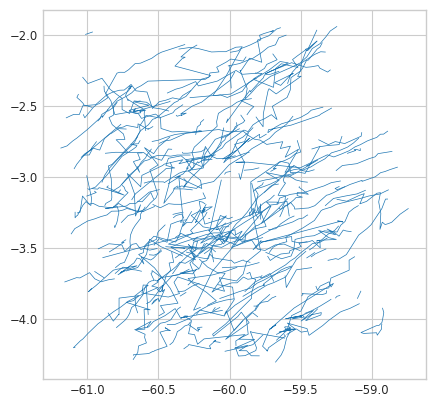

In [18]:
clusters_geom2.loc[(clusters_geom2["timestamp"].dt.year == 2014) & (clusters_geom2["timestamp"].dt.month == 1)].point.plot(linewidth=0.5)

In [19]:
systems_initend = clusters_geom2.rename(columns={"geom_name": "name"})
systems_initend["init"] = gpd.GeoSeries(None)
systems_initend["end"] = gpd.GeoSeries(None)

for index, row in systems_initend.iterrows():
    coords = [(coords) for coords in list(row['point'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    systems_initend.at[index,'init'] = Point(first_coord)
    systems_initend.at[index,'end'] = Point(last_coord)

systems_initend["x"] = systems_initend.init.x
systems_initend["y"] = systems_initend.init.y
systems_initend["dx"] = systems_initend.end.x - systems_initend.init.x
systems_initend["dy"] = systems_initend.end.y - systems_initend.init.y
systems_initend["u"] = np.cos(np.arctan2(systems_initend.dy, systems_initend.dx))
systems_initend["v"] = np.sin(np.arctan2(systems_initend.dy, systems_initend.dx))
systems_initend["bearing"] = (np.degrees(np.arctan2(systems_initend.dy, systems_initend.dx)) + 360) % 360
systems_initend["distance"] = ((systems_initend.dx)**2 + (systems_initend.dy)**2)**(1/2)
systems_initend

,point,timestamp,init,end,x,y,dx,dy,u,v,bearing,distance
geom_name,,,,,,,,,,,,
001a638b-9e79-4a0d-841c-1d11dc8f0033,"LINESTRING (-59.858 -2.200, -59.845 -2.174, -5...",2014-05-11 02:36:00-04:00,POINT (-59.85809 -2.19959),POINT (-59.93449 -2.21214),-59.858086,-2.199589,-0.076405,-0.012552,-0.986773,-0.162111,189.329425,0.077429
0027db84-eaa5-4797-a79a-fb0827caf5f0,"LINESTRING (-59.916 -2.844, -59.948 -2.615)",2014-08-04 14:00:00-04:00,POINT (-59.91600 -2.84436),POINT (-59.94825 -2.61463),-59.915997,-2.844357,-0.032253,0.229730,-0.139033,0.990288,97.991888,0.231983
00323c70-9b13-433c-8948-51c4ad50d5f1,"LINESTRING (-59.413 -3.870, -59.433 -3.890, -5...",2014-09-16 14:00:00-04:00,POINT (-59.41308 -3.87017),POINT (-59.64780 -3.98869),-59.413078,-3.870166,-0.234722,-0.118524,-0.892652,-0.450747,206.791620,0.262949
00380dde-e0cb-4643-8a93-ec23f2ab6f05,"LINESTRING (-59.023 -4.234, -59.021 -4.217, -5...",2015-11-25 13:36:00-04:00,POINT (-59.02261 -4.23385),POINT (-59.07812 -4.07113),-59.022610,-4.233848,-0.055511,0.162719,-0.322878,0.946441,108.837064,0.171927
00490023-ef13-45f2-a8be-231ab1ced9c2,"LINESTRING (-60.222 -3.932, -60.265 -3.932, -6...",2014-12-18 13:00:00-04:00,POINT (-60.22170 -3.93236),POINT (-60.35667 -4.00660),-60.221703,-3.932364,-0.134972,-0.074239,-0.876204,-0.481941,208.812223,0.154041
...,...,...,...,...,...,...,...,...,...,...,...,...
ffa56c84-d5b0-4844-a215-762f31709645,"LINESTRING (-59.692 -3.474, -59.745 -3.468, -5...",2014-05-24 06:24:00-04:00,POINT (-59.69173 -3.47434),POINT (-59.81546 -3.47763),-59.691734,-3.474338,-0.123730,-0.003295,-0.999646,-0.026623,181.525547,0.123774
ffa5c0c7-b228-48dc-9c0f-343016931db3,"LINESTRING (-59.410 -3.431, -59.434 -3.431)",2015-11-04 11:48:00-04:00,POINT (-59.41026 -3.43108),POINT (-59.43444 -3.43119),-59.410263,-3.431075,-0.024178,-0.000110,-0.999990,-0.004556,180.261029,0.024178
ffbe475f-5afa-4611-b1ca-4cec704f2e64,"LINESTRING (-60.244 -3.067, -60.268 -3.006, -6...",2014-03-05 12:24:00-04:00,POINT (-60.24401 -3.06733),POINT (-60.77460 -3.26386),-60.244007,-3.067331,-0.530594,-0.196527,-0.937742,-0.347331,200.324181,0.565820


In [20]:
freq_df = pd.DataFrame({"angle_freq": (np.radians(systems_initend.bearing).value_counts(bins=np.arange(0,2.1*np.pi,np.radians(22.5)), normalize=True)*100)}).sort_index()

In [21]:
freq_df.rename(index=dict(zip(freq_df.index.values, freq_df.index.left)), inplace=True)

Text(0.5, 1.0, 'Propagation Direction of Convective Systems')

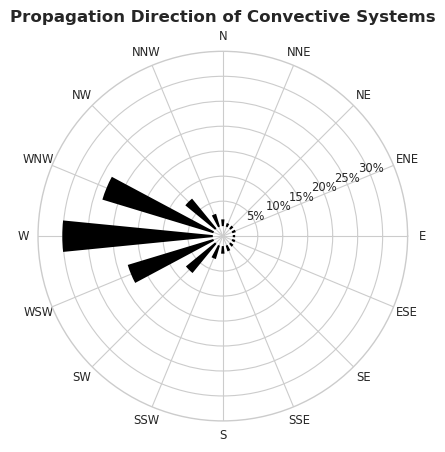

In [22]:
geo_labels = ["E", "ENE", "NE", "NNE", "N", "NNW", "NW", "WNW", "W", "WSW", "SW", "SSW", "S", "SSE", "SE", "ESE"]

fig = plt.figure()
gs = fig.add_gridspec(1,1)

ax = fig.add_subplot(gs[0], polar=True)
ax.bar(x=freq_df.index.values, height=freq_df.angle_freq, width=np.pi/16, color="k", align="center")
ax.set_ylim((-2, 35))
ax.set_xticks(ticks=np.arange(0,2*np.pi,np.radians(22.5)), labels=geo_labels)
ax.set_yticks(ticks=ax.get_yticks()[1:-1], labels=ax.get_yticklabels()[1:-1], ha="center")
ax.yaxis.set_major_formatter("{x:,.0f}%")
ax.set_title("Propagation Direction of Convective Systems", fontweight="bold")


<AxesSubplot:>

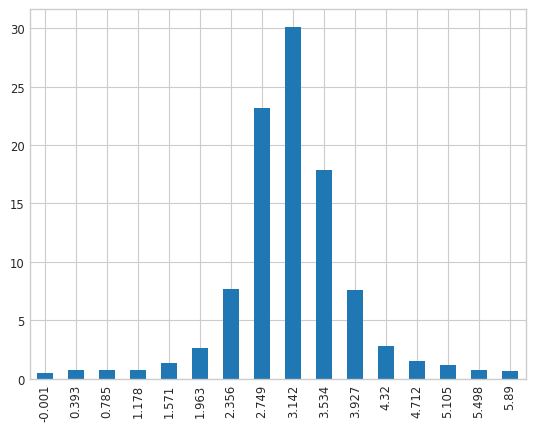

In [23]:
freq_df.angle_freq.plot(kind="bar")

/home/camilacl/miniconda3/envs/env-tathu/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:845: UserWarning: Approximating coordinate system <Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
/home/camilacl/miniconda3/envs/env-tathu/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:845: UserWarning: Approximating coordinate system <Geographic 2D CRS: +proj=lonlat +datum=WGS84 +ellps=WGS84 +no_defs +t ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warning

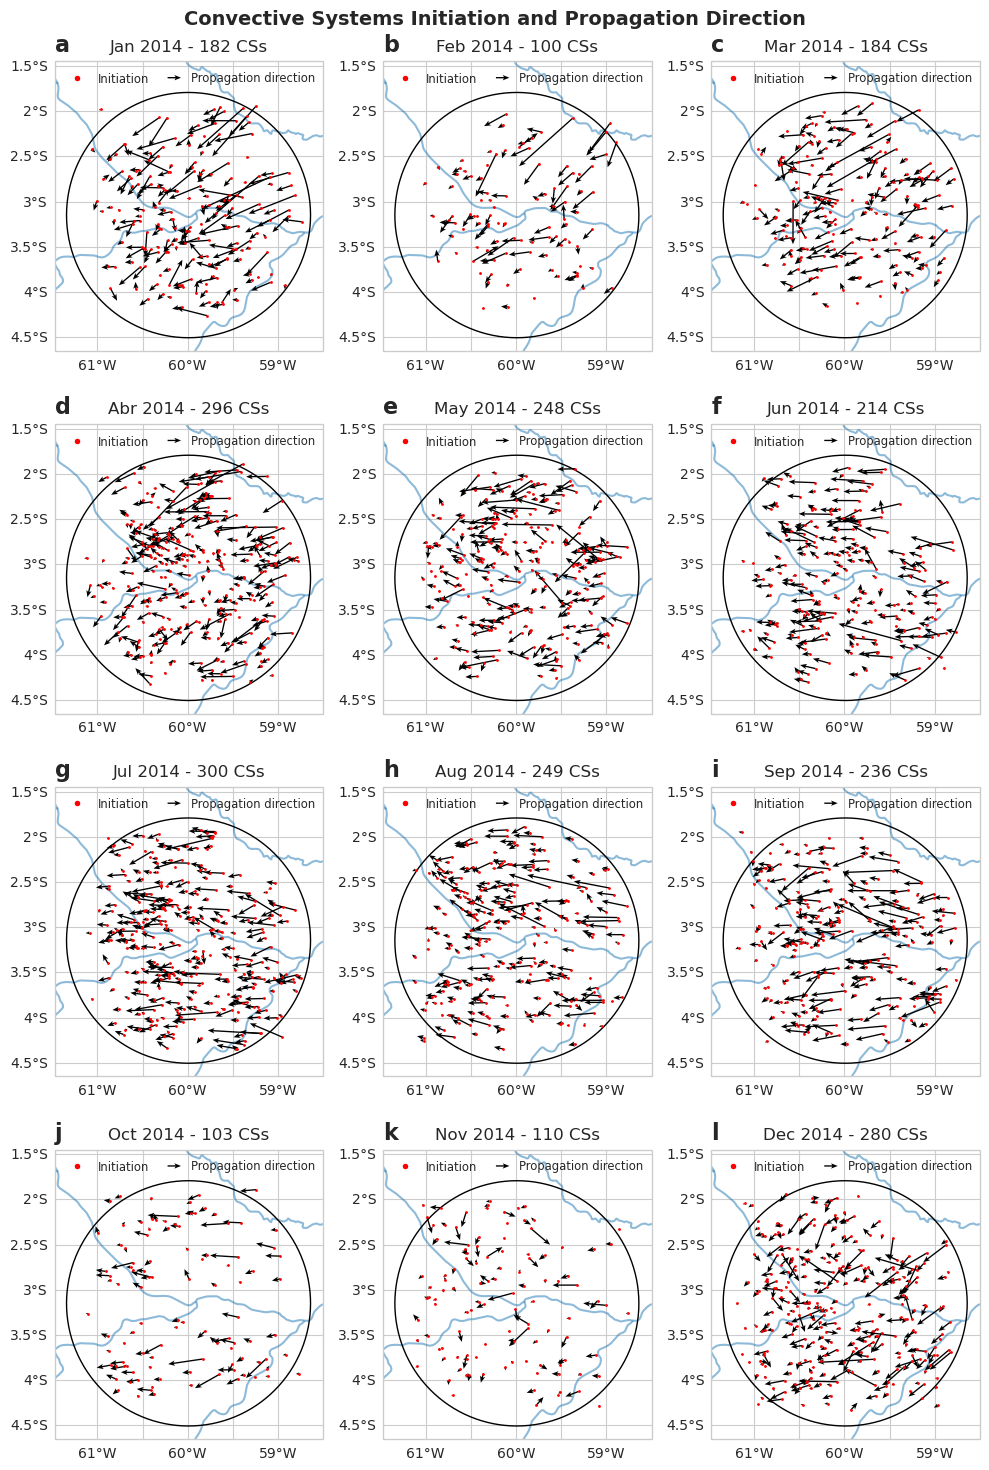

In [20]:
qlegend = [
    Line2D([0], [0], marker='o', color='w', label='Initiation', markerfacecolor='r', markersize=5)
]

months = [1,2,3,4,5,6,7,8,9,10,11,12]
months_names = ["Jan", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
figlabels = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l"]

crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,15))
gs = fig.add_gridspec(4,3)

for month, name, flabel in zip(months, months_names, figlabels):
    mon_geom = systems_initend.loc[(systems_initend["timestamp"].dt.year == 2014) & (systems_initend["timestamp"].dt.month == month)]
    ax = fig.add_subplot(gs[month-1], projection=crs)
    ax_plt = mon_geom.to_crs(crs.proj4_init).init.plot(color="r", markersize=1, ax=ax, zorder=3)
    ax_qv = ax.quiver(mon_geom["x"], mon_geom["y"], mon_geom["distance"], mon_geom["distance"], angles=mon_geom["bearing"], scale=10, headaxislength=4, headwidth=4, width=0.005, transform=crs, zorder=2)
    # clusters_geom2.loc[(clusters_geom2["timestamp"].dt.year == 2014) & (clusters_geom2["timestamp"].dt.month == 1) & (clusters_geom2["timestamp"].dt.day.isin([3,4,5]))].point.plot(color="g", ax=ax)
    ax_plt.set_xlim((-61.47, -58.5))
    ax_plt.set_ylim((-4.65, -1.45))  # (-4.65, -1.65)
    ax_plt.set_xlabel("Longitude (°)")
    ax_plt.set_ylabel("Latitude (°)")
    rivers.to_crs(crs.proj4_init).plot(alpha=0.5, ax=ax, zorder=1)
    ax.tissot(rad_km=150, lons=[-59.991,], lats=[-3.149,], n_samples=128, facecolor="none", zorder=1)
    gl = ax.gridlines(crs=crs, draw_labels=True, zorder=0)
    gl.top_labels = False
    gl.right_labels = False
    ax_plt.legend(handles=qlegend, loc="upper left", fontsize="small")
    ax.quiverkey(ax_qv, 0.47, 0.944, 0.5, "Propagation direction", labelpos="E", coordinates="axes", fontproperties={"size": "small"})
    ax_plt.set_title(name + " 2014 - " + str(len(mon_geom)) + " CSs")
    ax_plt.set_title(flabel, loc="left", fontweight="bold", size=16)

fig.suptitle("Convective Systems Initiation and Propagation Direction", size=14, fontweight="bold")

gs.tight_layout(fig)

### Echotops, derivada de echotops

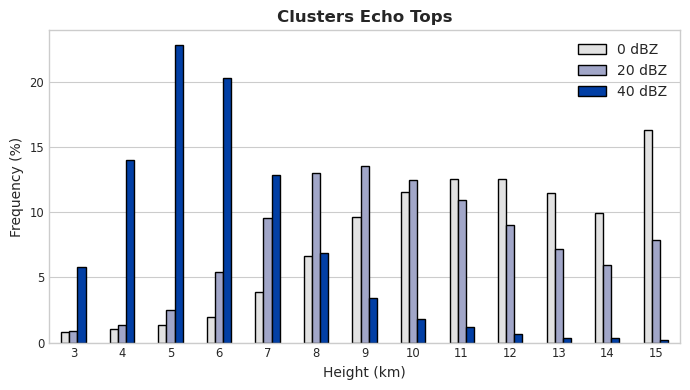

In [40]:
tops = pd.DataFrame({"0 dBZ": (systems_all["echotop_0"].value_counts()/len(systems_all)*100),
                     "20 dBZ": (systems_all["echotop_20"].value_counts()/len(systems_all)*100),
                     "40 dBZ": (systems_all["echotop_40"].value_counts()/len(systems_all)*100)}).drop(index=0)

fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])
ax_echo = tops.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), edgecolor="k", ax=ax1)
ax_echo.grid(axis="x")
ax_echo.set_xlabel("Height (km)")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
ax_echo.set_title("Clusters Echo Tops", fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_echotops.png", dpi=300, facecolor="none")

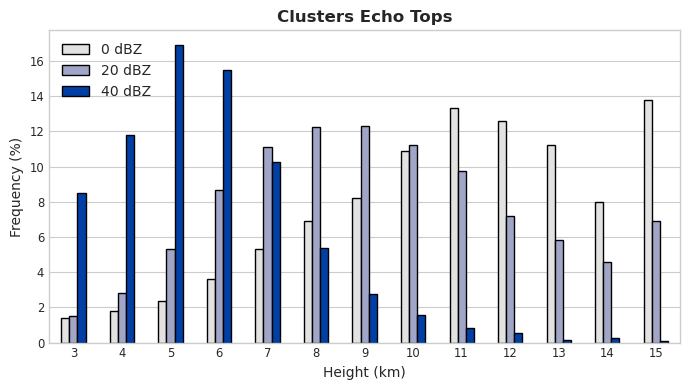

In [45]:
tops = pd.DataFrame({"0 dBZ": (systems_all.groupby("geom_name").tail(1).echotop_0.value_counts(normalize=True)*100),
                     "20 dBZ": (systems_all.groupby("geom_name").tail(1).echotop_20.value_counts(normalize=True)*100),
                     "40 dBZ": (systems_all.groupby("geom_name").tail(1).echotop_40.value_counts(normalize=True)*100)}).drop(index=0)

fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])
ax_echo = tops.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), edgecolor="k", ax=ax1)
ax_echo.grid(axis="x")
ax_echo.set_xlabel("Height (km)")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
ax_echo.set_title("Clusters Echo Tops", fontweight="bold")

gs.tight_layout(fig)

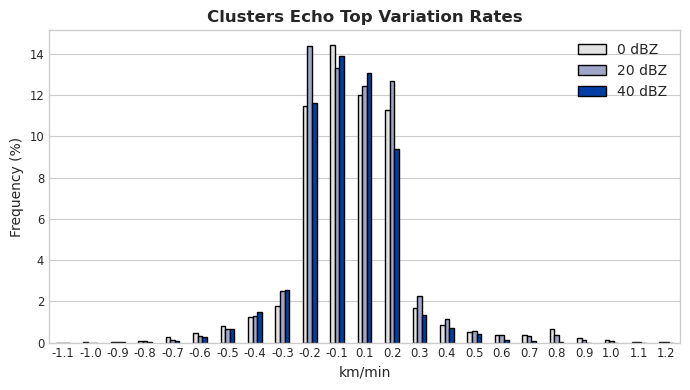

In [55]:
tops = pd.DataFrame({"0 dBZ": (systems_all["dechotop_0"].value_counts()/len(systems_all)*100),
                     "20 dBZ": (systems_all["dechotop_20"].value_counts()/len(systems_all)*100),
                     "40 dBZ": (systems_all["dechotop_40"].value_counts()/len(systems_all)*100)}).drop(index=0)


fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])
ax_echo = tops.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), edgecolor="k", ax=ax1)
ax_echo.grid(axis="x")
ax_echo.set_xlabel("km/min")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
ax_echo.set_title("Clusters Echo Top Variation Rates", fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_dechotops.png", dpi=300, facecolor="none")

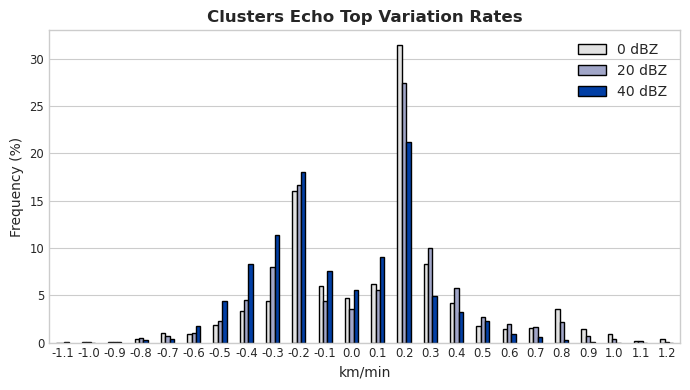

In [81]:
tops = pd.DataFrame({"0 dBZ": (systems_all.dropna().groupby("geom_name").agg({'dechotop_0': lambda x: max(x, key=abs)}).value_counts(normalize=True)*100),
                     "20 dBZ": (systems_all.dropna().groupby("geom_name").agg({'dechotop_20': lambda x: max(x, key=abs)}).value_counts(normalize=True)*100),
                     "40 dBZ": (systems_all.dropna().groupby("geom_name").agg({'dechotop_40': lambda x: max(x, key=abs)}).value_counts(normalize=True)*100)})


fig = plt.figure(figsize=(7,4))
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])
ax_echo = tops.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), edgecolor="k", ax=ax1)
ax_echo.grid(axis="x")
ax_echo.set_xlabel("km/min")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax1.get_xticks(), np.round(np.arange(-1.1, 1.25, 0.1),1), rotation=0)
ax_echo.set_title("Clusters Echo Top Variation Rates", fontweight="bold")

gs.tight_layout(fig)

In [80]:
np.round(np.arange(-1.1, 1.25, 0.1),1)

array([-1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,
        0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2])

### Echotops per season/IOPs

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_wet = systems_all.loc[systems_all["timestamp"].dt.month.isin([1,2,3])]
systems_all_dry = systems_all.loc[systems_all["timestamp"].dt.month.isin([8,9,10])]
systems_all_drytowet = systems_all.loc[systems_all["timestamp"].dt.month.isin([11,12])]

# custom_legend_wet = [Patch(facecolor="#E2E2E2", edgecolor="k", label="0 dBZ (total = " + str(int(systems_all_wet.echotop_0.count())) + ")"),
#                 Patch(facecolor="#A1A6C8", edgecolor="k", label="20 dBZ (total = " + str(int(systems_all_wet.echotop_20.count())) + ")"),
#                 Patch(facecolor="#023FA5", edgecolor="k", label="40 dBZ (total = " + str(int(systems_all_wet.echotop_40.count())) + ")")]
# custom_legend_dry = [Patch(facecolor="#E2E2E2", edgecolor="k", label="0 dBZ (total = " + str(int(systems_all_dry.echotop_0.count())) + ")"),
#                 Patch(facecolor="#A1A6C8", edgecolor="k", label="20 dBZ (total = " + str(int(systems_all_dry.echotop_20.count())) + ")"),
#                 Patch(facecolor="#023FA5", edgecolor="k", label="40 dBZ (total = " + str(int(systems_all_dry.echotop_40.count())) + ")")]
# custom_legend_drytowet = [Patch(facecolor="#E2E2E2", edgecolor="k", label="0 dBZ (total = " + str(int(systems_all_drytowet.echotop_0.count())) + ")"),
#                 Patch(facecolor="#A1A6C8", edgecolor="k", label="20 dBZ (total = " + str(int(systems_all_drytowet.echotop_20.count())) + ")"),
#                 Patch(facecolor="#023FA5", edgecolor="k", label="40 dBZ (total = " + str(int(systems_all_drytowet.echotop_40.count())) + ")")]

tops_wet = pd.DataFrame({"0 dBZ": (systems_all_wet["echotop_0"].value_counts()/len(systems_all_wet)*100),
                     "20 dBZ": (systems_all_wet["echotop_20"].value_counts()/len(systems_all_wet)*100),
                     "40 dBZ": (systems_all_wet["echotop_40"].value_counts()/len(systems_all_wet)*100)}).drop(index=0)
tops_dry = pd.DataFrame({"0 dBZ": (systems_all_dry["echotop_0"].value_counts()/len(systems_all_dry)*100),
                     "20 dBZ": (systems_all_dry["echotop_20"].value_counts()/len(systems_all_dry)*100),
                     "40 dBZ": (systems_all_dry["echotop_40"].value_counts()/len(systems_all_dry)*100)}).drop(index=0)
tops_drytowet = pd.DataFrame({"0 dBZ": (systems_all_drytowet["echotop_0"].value_counts()/len(systems_all_drytowet)*100),
                     "20 dBZ": (systems_all_drytowet["echotop_20"].value_counts()/len(systems_all_drytowet)*100),
                     "40 dBZ": (systems_all_drytowet["echotop_40"].value_counts()/len(systems_all_drytowet)*100)}).drop(index=0)

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax_echo = tops_dry.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), edgecolor="k", ax=ax1)
ax_echo.grid(axis="x")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
ax_echo.set_title("Dry Season")
ax_echo.legend(loc="upper left")
# ax_echo.legend(handles=custom_legend_dry, loc='upper left')

ax2 = fig.add_subplot(gs[1,0])
ax_echo = tops_drytowet.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), edgecolor="k", ax=ax2)
ax_echo.grid(axis="x")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=0)
ax_echo.set_title("Dry-to-Wet Season")
ax_echo.legend(loc="upper left")
# ax_echo.legend(handles=custom_legend_drytowet, loc='upper left')

ax3 = fig.add_subplot(gs[2,0])
ax_echo = tops_wet.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), edgecolor="k", ax=ax3)
ax_echo.grid(axis="x")
ax_echo.set_xlabel("Height (km)")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=0)
ax_echo.set_title("Wet Season")
ax_echo.legend(loc="upper left")
# ax_echo.legend(handles=custom_legend_wet, loc='upper left')

fig.suptitle("Clusters echo tops", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_echotops_seasons.png", dpi=300, facecolor="none")

In [ ]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_iop1 = systems_all.loc[(systems_all["timestamp"].dt.month.isin([2,3])) & (systems_all["timestamp"].dt.year == 2014)]
systems_all_iop2 = systems_all.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()

tops_iop1 = pd.DataFrame({"0 dBZ": (systems_all_iop1["echotop_0"].value_counts()/len(systems_all_iop1)*100),
                     "20 dBZ": (systems_all_iop1["echotop_20"].value_counts()/len(systems_all_iop1)*100),
                     "40 dBZ": (systems_all_iop1["echotop_40"].value_counts()/len(systems_all_iop1)*100)}).drop(index=0)
tops_iop2 = pd.DataFrame({"0 dBZ": (systems_all_iop2["echotop_0"].value_counts()/len(systems_all_iop2)*100),
                     "20 dBZ": (systems_all_iop2["echotop_20"].value_counts()/len(systems_all_iop2)*100),
                     "40 dBZ": (systems_all_iop2["echotop_40"].value_counts()/len(systems_all_iop2)*100)}).drop(index=0)

fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
ax_echo = tops_iop1.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), edgecolor="k", ax=ax1)
ax_echo.grid(axis="x")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=0)
ax_echo.set_title("IOP1 (Wet Season)")
ax_echo.legend(loc="upper left")

ax2 = fig.add_subplot(gs[1,0])
ax_echo = tops_iop2.plot(kind="bar", color=("#E2E2E2","#A1A6C8", "#023FA5"), edgecolor="k", ax=ax2)
ax_echo.grid(axis="x")
ax_echo.set_xlabel("Height (km)")
ax_echo.set_ylabel("Frequency (%)")
ax_echo.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=0)
ax_echo.set_title("IOP2 (Dry Season)")
ax_echo.legend(loc="upper left")

fig.suptitle("Clusters echo tops", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_echotops_iops.png", dpi=300, facecolor="none")

### CFAD (zfreq)

In [ ]:
ax1.get_xticks()

/tmp/ipykernel_871682/3871803469.py:7: RuntimeWarning: invalid value encountered in divide
  axplot = plt.contourf(cfad/np.sum(cfad, axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
/tmp/ipykernel_871682/3871803469.py:15: RuntimeWarning: invalid value encountered in divide
  plt.contour(cfad/np.sum(cfad, axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), colors="k", linewidths=0.5)


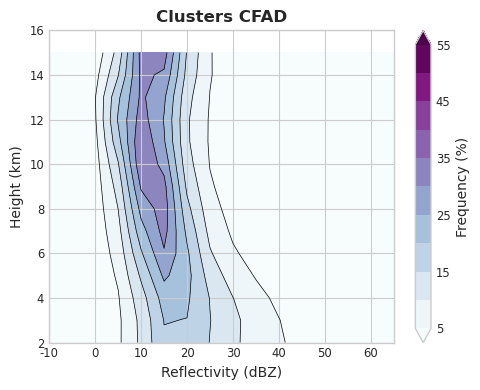

In [61]:
cfad = np.sum(zfreq, axis=0)

fig = plt.figure(figsize=(5,4))
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])
axplot = plt.contourf(cfad/np.sum(cfad, axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
ax1.set_xticks(range(0,16,2), range(-10,70,10))
ax1.set_yticks(ax1.get_yticks(), range(2,17,2))
ax1.set_xlabel("Reflectivity (dBZ)")
ax1.set_ylabel("Height (km)")
ax1.set_title("Clusters CFAD", fontweight="bold")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Frequency (%)")
plt.contour(cfad/np.sum(cfad, axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), colors="k", linewidths=0.5)

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_cfad.png", dpi=300, facecolor="none")

### CFAD por estação/IOP

/tmp/ipykernel_871682/1315100231.py:14: RuntimeWarning: invalid value encountered in divide
  plt.contourf(cfad_dry/cfad_dry.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
/tmp/ipykernel_871682/1315100231.py:22: RuntimeWarning: invalid value encountered in divide
  plt.contour(cfad_dry/cfad_dry.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), colors="k", linewidths=0.5)
/tmp/ipykernel_871682/1315100231.py:25: RuntimeWarning: invalid value encountered in divide
  plt.contourf(cfad_drytowet/cfad_drytowet.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
/tmp/ipykernel_871682/1315100231.py:33: RuntimeWarning: invalid value encountered in divide
  plt.contour(cfad_drytowet/cfad_drytowet.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), colors="k", linewidths=0.5)
/tmp/ipykernel_871682/1315100231.py:36: RuntimeWarning: invalid value encountere

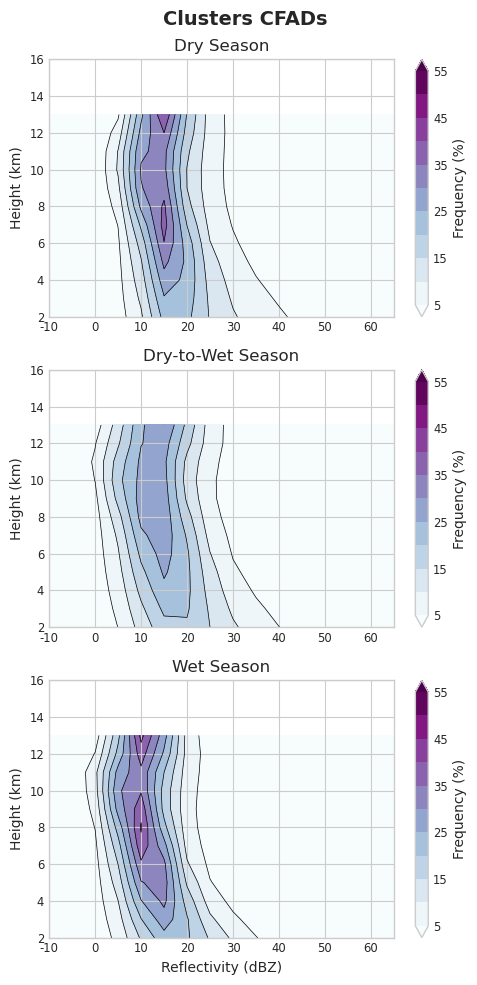

In [7]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_wet = systems_all.loc[systems_all["timestamp"].dt.month.isin([1,2,3])]
systems_all_dry = systems_all.loc[systems_all["timestamp"].dt.month.isin([8,9,10])]
systems_all_drytowet = systems_all.loc[systems_all["timestamp"].dt.month.isin([11,12])]

cfad_wet = np.sum([zfreq[i] for i in systems_all_wet.index.to_list()], axis=0)
cfad_dry = np.sum([zfreq[i] for i in systems_all_dry.index.to_list()], axis=0)
cfad_drytowet = np.sum([zfreq[i] for i in systems_all_drytowet.index.to_list()], axis=0)

fig = plt.figure(figsize=(5,10))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
plt.contourf(cfad_dry/cfad_dry.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
ax1.set_xticks(range(0,16,2), range(-10,70,10))
ax1.set_yticks(ax1.get_yticks(), range(2,17,2))
ax1.set_ylabel("Height (km)")
ax1.set_title("Dry Season")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Frequency (%)")
plt.contour(cfad_dry/cfad_dry.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), colors="k", linewidths=0.5)

ax2 = fig.add_subplot(gs[1,0])
plt.contourf(cfad_drytowet/cfad_drytowet.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
ax2.set_xticks(range(0,16,2), range(-10,70,10))
ax2.set_yticks(ax2.get_yticks(), range(2,17,2))
ax2.set_ylabel("Height (km)")
ax2.set_title("Dry-to-Wet Season")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Frequency (%)")
plt.contour(cfad_drytowet/cfad_drytowet.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), colors="k", linewidths=0.5)

ax3 = fig.add_subplot(gs[2,0])
plt.contourf(cfad_wet/cfad_wet.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
ax3.set_xticks(range(0,16,2), range(-10,70,10))
ax3.set_yticks(ax3.get_yticks(), range(2,17,2))
ax3.set_xlabel("Reflectivity (dBZ)")
ax3.set_ylabel("Height (km)")
ax3.set_title("Wet Season")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Frequency (%)")
plt.contour(cfad_wet/cfad_wet.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), colors="k", linewidths=0.5)

fig.suptitle("Clusters CFADs", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_cfad_seasons.png", dpi=300, facecolor="none")

/tmp/ipykernel_871682/826946834.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  systems_all_iop2 = systems_all.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()
/tmp/ipykernel_871682/826946834.py:12: RuntimeWarning: invalid value encountered in divide
  plt.contourf(cfad_iop1/cfad_iop1.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
/tmp/ipykernel_871682/826946834.py:20: RuntimeWarning: invalid value encountered in divide
  plt.contour(cfad_iop1/cfad_iop1.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), colors="k", linewidths=0.5)
/tmp/ipykernel_871682/826946834.py:23: RuntimeWarning: invalid value encountered in divide
  plt.contourf(cfad_iop2/cfad_iop2.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
/tmp/ipykernel_871682/82

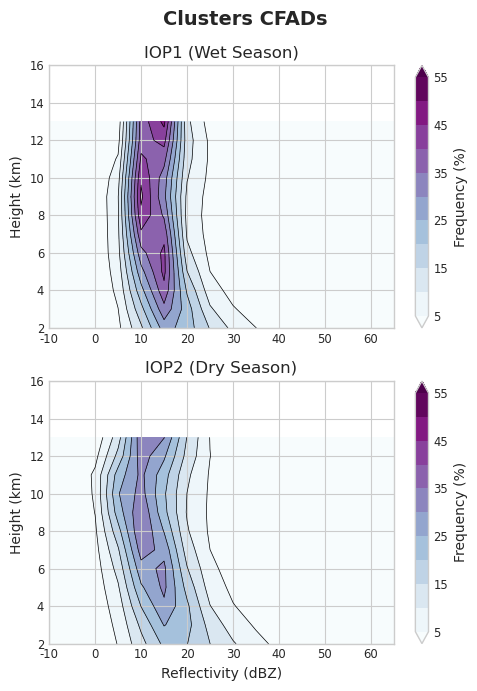

In [8]:
# Definição das estações/IOPs: Machado et al. (2018)
systems_all_iop1 = systems_all.loc[(systems_all["timestamp"].dt.month.isin([2,3])) & (systems_all["timestamp"].dt.year == 2014)]
systems_all_iop2 = systems_all.set_index(["timestamp"]).loc["2014-8-15":"2014-10-15"].reset_index()

cfad_iop1 = np.sum([zfreq[i] for i in systems_all_iop1.index.to_list()], axis=0)
cfad_iop2 = np.sum([zfreq[i] for i in systems_all_iop2.index.to_list()], axis=0)

fig = plt.figure(figsize=(5,7))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0,0])
plt.contourf(cfad_iop1/cfad_iop1.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
ax1.set_xticks(range(0,16,2), range(-10,70,10))
ax1.set_yticks(ax1.get_yticks(), range(2,17,2))
ax1.set_ylabel("Height (km)")
ax1.set_title("IOP1 (Wet Season)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Frequency (%)")
plt.contour(cfad_iop1/cfad_iop1.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), colors="k", linewidths=0.5)

ax2 = fig.add_subplot(gs[1,0])
plt.contourf(cfad_iop2/cfad_iop2.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), cmap="BuPu", zorder=0)
ax2.set_xticks(range(0,16,2), range(-10,70,10))
ax2.set_yticks(ax2.get_yticks(), range(2,17,2))
ax2.set_ylabel("Height (km)")
ax2.set_xlabel("Reflectivity (dBZ)")
ax2.set_title("IOP2 (Dry Season)")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Frequency (%)")
plt.contour(cfad_iop2/cfad_iop2.sum(axis=1, keepdims=True)*100, extend="both", levels=np.arange(5, 60, 5), colors="k", linewidths=0.5)

fig.suptitle("Clusters CFADs", size=14, fontweight="bold")

gs.tight_layout(fig)

plt.savefig("out/goamazon/exploratory_stats_cfad_iops.png", dpi=300, facecolor="none")

In [14]:
cfad_dry_wet = (cfad_dry/cfad_dry.sum(axis=1, keepdims=True)*100) - (cfad_wet/cfad_wet.sum(axis=1, keepdims=True)*100)
cfad_drytowet_wet = (cfad_drytowet/cfad_drytowet.sum(axis=1, keepdims=True)*100) - (cfad_wet/cfad_wet.sum(axis=1, keepdims=True)*100)
cfad_drytowet_dry = (cfad_drytowet/cfad_drytowet.sum(axis=1, keepdims=True)*100) - (cfad_dry/cfad_dry.sum(axis=1, keepdims=True)*100)
cfad_iop1_iop2 = (cfad_iop1/cfad_iop1.sum(axis=1, keepdims=True)*100) - (cfad_iop2/cfad_iop2.sum(axis=1, keepdims=True)*100)

/tmp/ipykernel_871682/1056359004.py:1: RuntimeWarning: invalid value encountered in divide
  cfad_dry_wet = (cfad_dry/cfad_dry.sum(axis=1, keepdims=True)*100) - (cfad_wet/cfad_wet.sum(axis=1, keepdims=True)*100)
/tmp/ipykernel_871682/1056359004.py:2: RuntimeWarning: invalid value encountered in divide
  cfad_drytowet_wet = (cfad_drytowet/cfad_drytowet.sum(axis=1, keepdims=True)*100) - (cfad_wet/cfad_wet.sum(axis=1, keepdims=True)*100)
/tmp/ipykernel_871682/1056359004.py:3: RuntimeWarning: invalid value encountered in divide
  cfad_drytowet_dry = (cfad_drytowet/cfad_drytowet.sum(axis=1, keepdims=True)*100) - (cfad_dry/cfad_dry.sum(axis=1, keepdims=True)*100)
/tmp/ipykernel_871682/1056359004.py:4: RuntimeWarning: invalid value encountered in divide
  cfad_iop1_iop2 = (cfad_iop1/cfad_iop1.sum(axis=1, keepdims=True)*100) - (cfad_iop2/cfad_iop2.sum(axis=1, keepdims=True)*100)


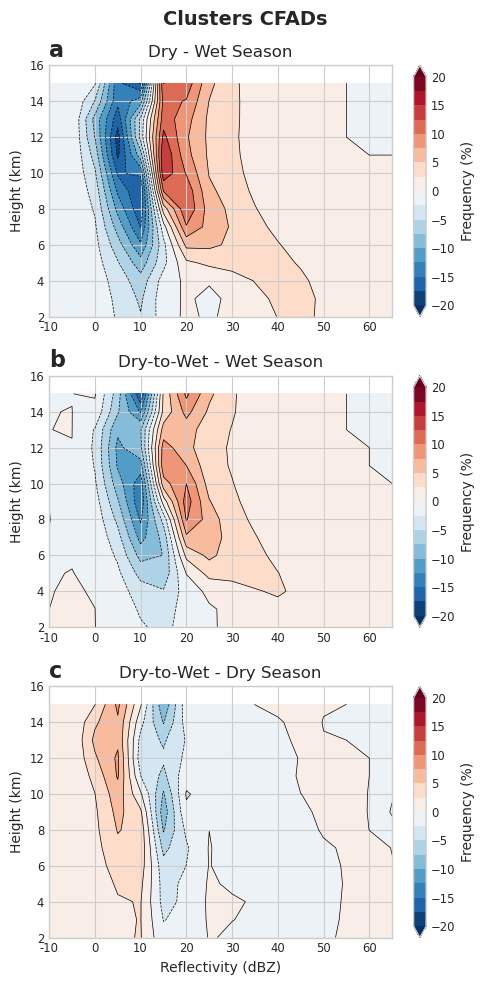

In [65]:
fig = plt.figure(figsize=(5,10))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
plt.contourf(cfad_dry_wet, extend="both", levels=np.arange(-20, 22, 2.5), cmap="RdBu_r", zorder=0)
ax1.set_xticks(range(0,16,2), range(-10,70,10))
ax1.set_yticks(ax1.get_yticks(), range(2,17,2))
ax1.set_ylabel("Height (km)")
ax1.set_title("Dry - Wet Season")
ax1.set_title("a", loc="left", fontweight="bold", size=16)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Frequency (%)")
plt.contour(cfad_dry_wet, extend="both", levels=np.arange(-20, 22, 2.5), colors="k", linewidths=0.5)

ax2 = fig.add_subplot(gs[1,0])
plt.contourf(cfad_drytowet_wet, extend="both", levels=np.arange(-20, 22, 2.5), cmap="RdBu_r", zorder=0)
ax2.set_xticks(range(0,16,2), range(-10,70,10))
ax2.set_yticks(ax2.get_yticks(), range(2,17,2))
ax2.set_ylabel("Height (km)")
ax2.set_title("Dry-to-Wet - Wet Season")
ax2.set_title("b", loc="left", fontweight="bold", size=16)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Frequency (%)")
plt.contour(cfad_drytowet_wet, extend="both", levels=np.arange(-20, 22, 2.5), colors="k", linewidths=0.5)

ax3 = fig.add_subplot(gs[2,0])
plt.contourf(cfad_drytowet_dry, extend="both", levels=np.arange(-20, 22, 2.5), cmap="RdBu_r", zorder=0)
ax3.set_xticks(range(0,16,2), range(-10,70,10))
ax3.set_yticks(ax3.get_yticks(), range(2,17,2))
ax3.set_xlabel("Reflectivity (dBZ)")
ax3.set_ylabel("Height (km)")
ax3.set_title("Dry-to-Wet - Dry Season")
ax3.set_title("c", loc="left", fontweight="bold", size=16)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Frequency (%)")
plt.contour(cfad_drytowet_dry, extend="both", levels=np.arange(-20, 22, 2.5), colors="k", linewidths=0.5)

fig.suptitle("Clusters CFADs", size=14, fontweight="bold")

gs.tight_layout(fig)

### VIL/VII

In [21]:
vii_0 = systems_all[["echotop_0", "vii", "timestamp", "geom_name"]].loc[systems_all.echotop_0 != 0]
vii_0["vii"] = pd.to_numeric(vii_0["vii"].apply(lambda x: x.flatten().tolist()).explode("vii"))
vii_0 = vii_0.loc[vii_0.vii > 0]

vil_20 = systems_all[["echotop_20", "vil", "timestamp", "geom_name"]].loc[systems_all.echotop_20 != 0]
vil_20["vil"] = pd.to_numeric(vil_20["vil"].apply(lambda x: x.flatten().tolist()).explode("vil"))
vil_20 = vil_20.loc[vil_20.vil > 0]

# vii_0_wet = 

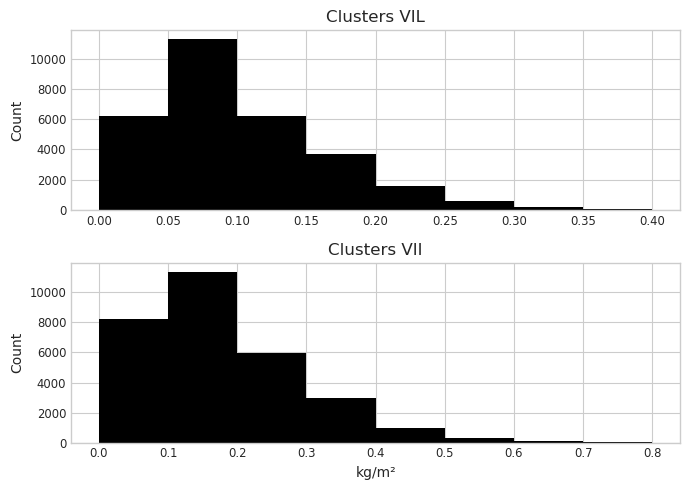

In [7]:
fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[1,0])
axplot = vii_0.vii.plot.hist(bins=np.arange(0,0.9,0.1), ax=ax1, color="k")
axplot.set_ylabel("Count")
axplot.set_xlabel("kg/m²")
axplot.set_title("Clusters VII")

ax2 = fig.add_subplot(gs[0,0])
axplot = vil_20.vil.plot.hist(bins=np.arange(0,0.45,0.05), ax=ax2, color="k")
axplot.set_ylabel("Count")
axplot.set_title("Clusters VIL")

gs.tight_layout(fig)

Text(0.5, 0.98, '')

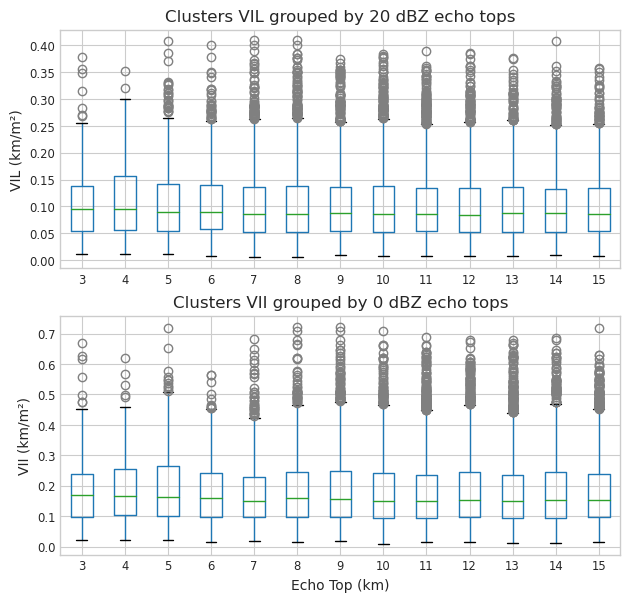

In [8]:
fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[1,0])
axplot = vii_0.boxplot(column="vii", by="echotop_0", flierprops=dict(markeredgecolor="gray", marker="o"), ax=ax1)
axplot.set_ylabel("VII (km/m²)")
axplot.set_xlabel("Echo Top (km)")
axplot.set_title("Clusters VII grouped by 0 dBZ echo tops")
plt.suptitle("")

ax2 = fig.add_subplot(gs[0,0])
axplot = vil_20.boxplot(column="vil", by="echotop_20", flierprops=dict(markeredgecolor="gray", marker="o"), ax=ax2)
axplot.set_ylabel("VIL (km/m²)")
axplot.set_xlabel("")
axplot.set_title("Clusters VIL grouped by 20 dBZ echo tops")
plt.suptitle("")

In [26]:
max_vii_0 = vii_0.loc[vii_0.groupby('geom_name')['vii'].idxmax()]
max_vil_20 = vil_20.loc[vil_20.groupby('geom_name')['vil'].idxmax()]

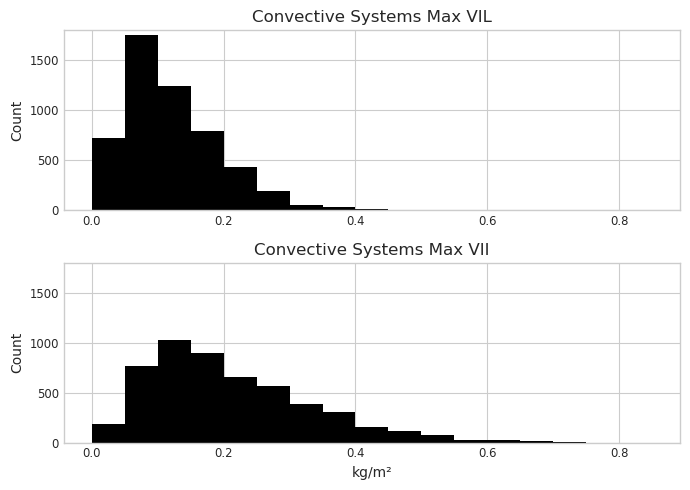

In [31]:
fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[1,0])
axplot = max_vii_0.vii.plot.hist(bins=np.arange(0,0.9,0.05), ax=ax1, color="k")
axplot.set_ylim((0,1800))
axplot.set_ylabel("Count")
axplot.set_xlabel("kg/m²")
axplot.set_title("Convective Systems Max VII")

ax2 = fig.add_subplot(gs[0,0])
axplot = max_vil_20.vil.plot.hist(bins=np.arange(0,0.9,0.05), ax=ax2, color="k")
axplot.set_ylim((0,1800))
axplot.set_ylabel("Count")
axplot.set_title("Convective Systems Max VIL")

gs.tight_layout(fig)

Text(0.5, 0.98, '')

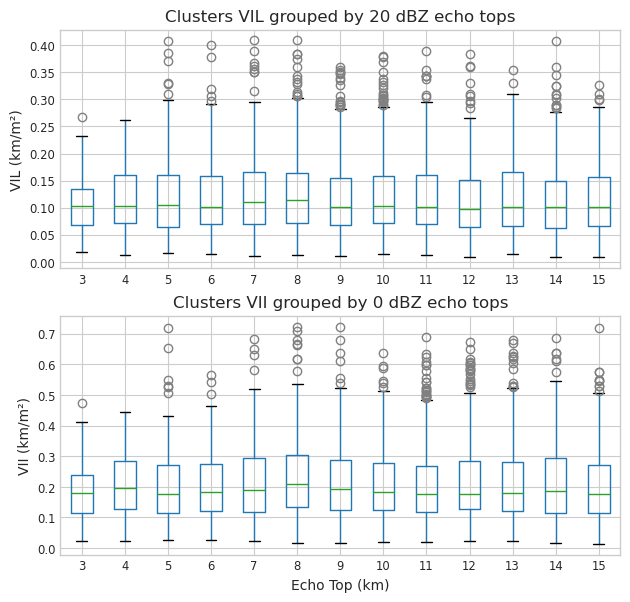

In [27]:
fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[1,0])
axplot = max_vii_0.boxplot(column="vii", by="echotop_0", flierprops=dict(markeredgecolor="gray", marker="o"), ax=ax1)
axplot.set_ylabel("VII (km/m²)")
axplot.set_xlabel("Echo Top (km)")
axplot.set_title("Convective Systems Max VII grouped by 0 dBZ echo tops")
plt.suptitle("")

ax2 = fig.add_subplot(gs[0,0])
axplot = max_vil_20.boxplot(column="vil", by="echotop_20", flierprops=dict(markeredgecolor="gray", marker="o"), ax=ax2)
axplot.set_ylabel("VIL (km/m²)")
axplot.set_xlabel("")
axplot.set_title("Convective Systems Max VIL grouped by 20 dBZ echo tops")
plt.suptitle("")

In [51]:
systems_all_wet = systems_all.loc[systems_all["timestamp"].dt.month.isin([1,2,3])]
systems_all_dry = systems_all.loc[systems_all["timestamp"].dt.month.isin([8,9,10])]
systems_all_drytowet = systems_all.loc[systems_all["timestamp"].dt.month.isin([11,12])]
systems_per_wet = systems_per.loc[systems_per["timestamp"].dt.month.isin([1,2,3])]
systems_per_dry = systems_per.loc[systems_per["timestamp"].dt.month.isin([8,9,10])]
systems_per_drytowet = systems_per.loc[systems_per["timestamp"].dt.month.isin([11,12])]

vii_0_wet = systems_all_wet[["echotop_0", "vii", "timestamp", "geom_name"]].loc[systems_all_wet.echotop_0 != 0]
vii_0_wet["vii"] = pd.to_numeric(vii_0_wet["vii"].apply(lambda x: x.flatten().tolist()).explode("vii"))
vii_0_wet = vii_0_wet.loc[vii_0_wet.vii > 0]
max_vii_0_wet = vii_0_wet.loc[vii_0_wet.groupby('geom_name')['vii'].idxmax()]
vil_20_wet = systems_all_wet[["echotop_20", "vil", "timestamp", "geom_name"]].loc[systems_all_wet.echotop_20 != 0]
vil_20_wet["vil"] = pd.to_numeric(vil_20_wet["vil"].apply(lambda x: x.flatten().tolist()).explode("vil"))
vil_20_wet = vil_20_wet.loc[vil_20_wet.vil > 0]
max_vil_20_wet = vil_20_wet.loc[vil_20_wet.groupby('geom_name')['vil'].idxmax()]

vii_0_drytowet = systems_all_drytowet[["echotop_0", "vii", "timestamp", "geom_name"]].loc[systems_all_drytowet.echotop_0 != 0]
vii_0_drytowet["vii"] = pd.to_numeric(vii_0_drytowet["vii"].apply(lambda x: x.flatten().tolist()).explode("vii"))
vii_0_drytowet = vii_0_drytowet.loc[vii_0_drytowet.vii > 0]
max_vii_0_drytowet = vii_0_drytowet.loc[vii_0_drytowet.groupby('geom_name')['vii'].idxmax()]
vil_20_drytowet = systems_all_drytowet[["echotop_20", "vil", "timestamp", "geom_name"]].loc[systems_all_drytowet.echotop_20 != 0]
vil_20_drytowet["vil"] = pd.to_numeric(vil_20_drytowet["vil"].apply(lambda x: x.flatten().tolist()).explode("vil"))
vil_20_drytowet = vil_20_drytowet.loc[vil_20_drytowet.vil > 0]
max_vil_20_drytowet = vil_20_drytowet.loc[vil_20_drytowet.groupby('geom_name')['vil'].idxmax()]

vii_0_dry = systems_all_dry[["echotop_0", "vii", "timestamp", "geom_name"]].loc[systems_all_dry.echotop_0 != 0]
vii_0_dry["vii"] = pd.to_numeric(vii_0_dry["vii"].apply(lambda x: x.flatten().tolist()).explode("vii"))
vii_0_dry = vii_0_dry.loc[vii_0_dry.vii > 0]
max_vii_0_dry = vii_0_dry.loc[vii_0_dry.groupby('geom_name')['vii'].idxmax()]
vil_20_dry = systems_all_dry[["echotop_20", "vil", "timestamp", "geom_name"]].loc[systems_all_dry.echotop_20 != 0]
vil_20_dry["vil"] = pd.to_numeric(vil_20_dry["vil"].apply(lambda x: x.flatten().tolist()).explode("vil"))
vil_20_dry = vil_20_dry.loc[vil_20_dry.vil > 0]
max_vil_20_dry = vil_20_dry.loc[vil_20_dry.groupby('geom_name')['vil'].idxmax()]

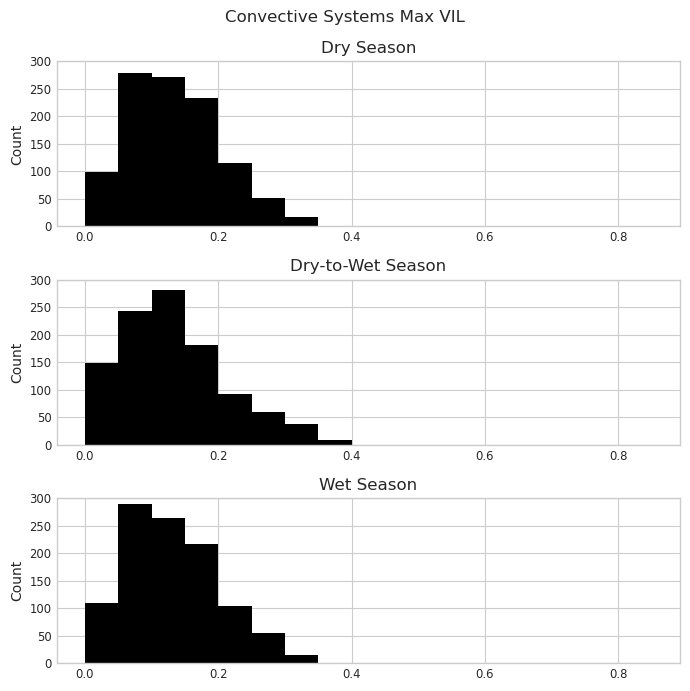

In [57]:
fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
axplot = max_vil_20_dry.vil.plot.hist(bins=np.arange(0,0.9,0.05), ax=ax1, color="k")
axplot.set_ylim((0,300))
axplot.set_ylabel("Count")
axplot.set_title("Dry Season")

ax2 = fig.add_subplot(gs[1,0])
axplot = max_vil_20_drytowet.vil.plot.hist(bins=np.arange(0,0.9,0.05), ax=ax2, color="k")
axplot.set_ylim((0,300))
axplot.set_ylabel("Count")
axplot.set_title("Dry-to-Wet Season")

ax3 = fig.add_subplot(gs[2,0])
axplot = max_vil_20_wet.vil.plot.hist(bins=np.arange(0,0.9,0.05), ax=ax3, color="k")
axplot.set_ylim((0,300))
axplot.set_ylabel("Count")
axplot.set_ylabel("Count")
axplot.set_title("Wet Season")

fig.suptitle("Convective Systems Max VIL")

gs.tight_layout(fig)

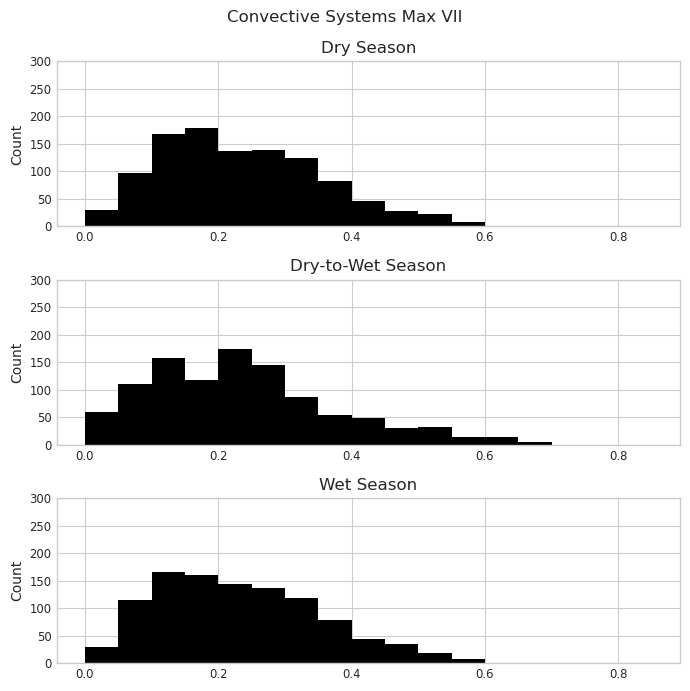

In [56]:
fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
axplot = max_vii_0_dry.vii.plot.hist(bins=np.arange(0,0.9,0.05), ax=ax1, color="k")
axplot.set_ylim((0,300))
axplot.set_ylabel("Count")
axplot.set_title("Dry Season")

ax2 = fig.add_subplot(gs[1,0])
axplot = max_vii_0_drytowet.vii.plot.hist(bins=np.arange(0,0.9,0.05), ax=ax2, color="k")
axplot.set_ylim((0,300))
axplot.set_ylabel("Count")
axplot.set_title("Dry-to-Wet Season")

ax3 = fig.add_subplot(gs[2,0])
axplot = max_vii_0_wet.vii.plot.hist(bins=np.arange(0,0.9,0.05), ax=ax3, color="k")
axplot.set_ylim((0,300))
axplot.set_ylabel("Count")
axplot.set_ylabel("Count")
axplot.set_title("Wet Season")

fig.suptitle("Convective Systems Max VII")

gs.tight_layout(fig)